# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
filename = 'hsd-coreset'
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [10]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [11]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [12]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [13]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [14]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [15]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [16]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [17]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [18]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [19]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def coreset_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        shuffle=False,
    )
    farthest_data = dict(farthest_point)
    
    model.eval()
    start_time = time.time()
    embeddings = []
    
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
        embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Use pairwise distances to compute a distance matrix for Coreset selection
        distance_matrix = pairwise_distances(embeddings)    
        selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
        
        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
        farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']
                
        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [21]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    farthest_point = manager.dict()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, farthest_point, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [22]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6046, Accuracy: 0.8193, F1 Micro: 0.1306, F1 Macro: 0.0476
Epoch 2/10, Train Loss: 0.4611, Accuracy: 0.8278, F1 Micro: 0.0018, F1 Macro: 0.0007
Epoch 3/10, Train Loss: 0.395, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.3942, Accuracy: 0.828, F1 Micro: 0.0029, F1 Macro: 0.0013
Epoch 5/10, Train Loss: 0.3771, Accuracy: 0.8331, F1 Micro: 0.0672, F1 Macro: 0.0277
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3693, Accuracy: 0.8492, F1 Micro: 0.2596, F1 Macro: 0.0906
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3465, Accuracy: 0.8548, F1 Micro: 0.3235, F1 Macro: 0.1092
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3297, Accuracy: 0.8708, F1 Micro: 0.4854, F1 Macro: 0.2134
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2965, Accuracy: 0.8761, F1 Micro: 0.5481, F1 Macro: 0.2668
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2714, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5094, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3406, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3147, Accuracy: 0.8278, F1 Micro: 0.0011, F1 Macro: 0.0004
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2825, Accuracy: 0.8505, F1 Micro: 0.2698, F1 Macro: 0.1058
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2507, Accuracy: 0.8669, F1 Micro: 0.4456, F1 Macro: 0.2683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2161, Accuracy: 0.877, F1 Micro: 0.6029, F1 Macro: 0.4024
Epoch 7/10, Train Loss: 0.1918, Accuracy: 0.8782, F1 Micro: 0.554, F1 Macro: 0.3802
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1829, Accuracy: 0.8838, F1 Micro: 0.6359, F1 Macro: 0.4363
Epoch 9/10, Train Loss: 0.1576, Accuracy: 0.8849, F1 Micro: 0.5973, F1 Macro: 0.4341
Epoch 10/10, Train

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.489, Accuracy: 0.8426, F1 Micro: 0.3643, F1 Macro: 0.1127
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3461, Accuracy: 0.8508, F1 Micro: 0.5122, F1 Macro: 0.2297
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3004, Accuracy: 0.8742, F1 Micro: 0.56, F1 Macro: 0.2775
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2636, Accuracy: 0.8815, F1 Micro: 0.5932, F1 Macro: 0.367
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2326, Accuracy: 0.88, F1 Micro: 0.6455, F1 Macro: 0.3978
Epoch 6/10, Train Loss: 0.2182, Accuracy: 0.8875, F1 Micro: 0.6195, F1 Macro: 0.4242
Epoch 7/10, Train Loss: 0.1967, Accuracy: 0.8916, F1 Micro: 0.6325, F1 Macro: 0.4351
Epoch 8/10, Train Loss: 0.1701, Accuracy: 0.8907, F1 Micro: 0.6116, F1 Macro: 0.4279
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1475, Accuracy: 0.8936, F1 Micro: 0.6779, F1 Macro: 0.5281
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4563, Accuracy: 0.843, F1 Micro: 0.2722, F1 Macro: 0.1008
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3174, Accuracy: 0.8716, F1 Micro: 0.5709, F1 Macro: 0.2915
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2568, Accuracy: 0.8789, F1 Micro: 0.6198, F1 Macro: 0.4212
Epoch 4/10, Train Loss: 0.214, Accuracy: 0.8836, F1 Micro: 0.5877, F1 Macro: 0.3571
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2002, Accuracy: 0.8933, F1 Micro: 0.6589, F1 Macro: 0.49
Epoch 6/10, Train Loss: 0.1736, Accuracy: 0.8939, F1 Micro: 0.6479, F1 Macro: 0.5112
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1481, Accuracy: 0.8992, F1 Micro: 0.667, F1 Macro: 0.5131
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1255, Accuracy: 0.9021, F1 Micro: 0.6875, F1 Macro: 0.5617
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1126, Accuracy: 0.9019, F1 Micro: 0.6886, F1 Macro: 0.5733
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4563, Accuracy: 0.8495, F1 Micro: 0.428, F1 Macro: 0.1834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3177, Accuracy: 0.8821, F1 Micro: 0.5906, F1 Macro: 0.3483
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2606, Accuracy: 0.8912, F1 Micro: 0.6162, F1 Macro: 0.4104
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2166, Accuracy: 0.8976, F1 Micro: 0.6679, F1 Macro: 0.4784
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1906, Accuracy: 0.9008, F1 Micro: 0.6937, F1 Macro: 0.5265
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1641, Accuracy: 0.9054, F1 Micro: 0.7068, F1 Macro: 0.5704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1389, Accuracy: 0.9029, F1 Micro: 0.7166, F1 Macro: 0.5846
Epoch 8/10, Train Loss: 0.1219, Accuracy: 0.9075, F1 Micro: 0.7008, F1 Macro: 0.5679
Epoch 9/10, Train Loss: 0.1053, Accuracy: 0.9072, F1 Micro: 0.7118, F1 Macro: 0.6061
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4453, Accuracy: 0.8597, F1 Micro: 0.4461, F1 Macro: 0.1798
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3043, Accuracy: 0.8874, F1 Micro: 0.6513, F1 Macro: 0.4339
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2353, Accuracy: 0.8982, F1 Micro: 0.6785, F1 Macro: 0.474
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1979, Accuracy: 0.9017, F1 Micro: 0.7008, F1 Macro: 0.53
Epoch 5/10, Train Loss: 0.1742, Accuracy: 0.9056, F1 Micro: 0.7004, F1 Macro: 0.5417
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1543, Accuracy: 0.9042, F1 Micro: 0.7202, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1251, Accuracy: 0.9071, F1 Micro: 0.7227, F1 Macro: 0.6118
Epoch 8/10, Train Loss: 0.1098, Accuracy: 0.9046, F1 Micro: 0.7194, F1 Macro: 0.6073
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0953, Accuracy: 0.9074, F1 Micro: 0.7285, F1 Macro: 0.6191
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4372, Accuracy: 0.8688, F1 Micro: 0.5145, F1 Macro: 0.2303
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2956, Accuracy: 0.8918, F1 Micro: 0.6551, F1 Macro: 0.4247
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2352, Accuracy: 0.901, F1 Micro: 0.6809, F1 Macro: 0.4949
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1988, Accuracy: 0.904, F1 Micro: 0.7006, F1 Macro: 0.5214
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1699, Accuracy: 0.9089, F1 Micro: 0.7196, F1 Macro: 0.5696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1388, Accuracy: 0.9098, F1 Micro: 0.7307, F1 Macro: 0.6057
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1194, Accuracy: 0.9122, F1 Micro: 0.7336, F1 Macro: 0.615
Epoch 8/10, Train Loss: 0.1081, Accuracy: 0.9085, F1 Micro: 0.7335, F1 Macro: 0.6099
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0886, Accuracy: 0.9074, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4264, Accuracy: 0.8721, F1 Micro: 0.4963, F1 Macro: 0.2173
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2886, Accuracy: 0.8905, F1 Micro: 0.6856, F1 Macro: 0.4902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2314, Accuracy: 0.901, F1 Micro: 0.7008, F1 Macro: 0.5104
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1955, Accuracy: 0.9036, F1 Micro: 0.7248, F1 Macro: 0.5624
Epoch 5/10, Train Loss: 0.1632, Accuracy: 0.9116, F1 Micro: 0.7233, F1 Macro: 0.5748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.9105, F1 Micro: 0.7383, F1 Macro: 0.596
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1248, Accuracy: 0.9107, F1 Micro: 0.7406, F1 Macro: 0.6348
Epoch 8/10, Train Loss: 0.1012, Accuracy: 0.9141, F1 Micro: 0.7349, F1 Macro: 0.6423
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0898, Accuracy: 0.9142, F1 Micro: 0.7458, F1 Macro: 0.6564
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4206, Accuracy: 0.8774, F1 Micro: 0.549, F1 Macro: 0.2507
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2783, Accuracy: 0.8962, F1 Micro: 0.6725, F1 Macro: 0.4402
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2231, Accuracy: 0.9024, F1 Micro: 0.7087, F1 Macro: 0.5378
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.185, Accuracy: 0.91, F1 Micro: 0.7213, F1 Macro: 0.5645
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1604, Accuracy: 0.9125, F1 Micro: 0.7339, F1 Macro: 0.5791
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1309, Accuracy: 0.9116, F1 Micro: 0.7428, F1 Macro: 0.6214
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.114, Accuracy: 0.9129, F1 Micro: 0.745, F1 Macro: 0.6611
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0975, Accuracy: 0.9117, F1 Micro: 0.7466, F1 Macro: 0.6439
Epoch 9/10, Train Loss: 0.0829, Accuracy: 0.9142, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4114, Accuracy: 0.8788, F1 Micro: 0.5491, F1 Macro: 0.2588
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2767, Accuracy: 0.8981, F1 Micro: 0.6734, F1 Macro: 0.4677
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2177, Accuracy: 0.9029, F1 Micro: 0.6979, F1 Macro: 0.5228
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1851, Accuracy: 0.9084, F1 Micro: 0.731, F1 Macro: 0.5785
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1532, Accuracy: 0.9128, F1 Micro: 0.7379, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1325, Accuracy: 0.9089, F1 Micro: 0.7437, F1 Macro: 0.6152
Epoch 7/10, Train Loss: 0.1114, Accuracy: 0.9145, F1 Micro: 0.7302, F1 Macro: 0.6293
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0951, Accuracy: 0.9158, F1 Micro: 0.7438, F1 Macro: 0.642
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0832, Accuracy: 0.9145, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4089, Accuracy: 0.88, F1 Micro: 0.6014, F1 Macro: 0.2866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2707, Accuracy: 0.8983, F1 Micro: 0.6871, F1 Macro: 0.4806
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2137, Accuracy: 0.9064, F1 Micro: 0.7054, F1 Macro: 0.5132
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1795, Accuracy: 0.9105, F1 Micro: 0.7344, F1 Macro: 0.5889
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.9112, F1 Micro: 0.7412, F1 Macro: 0.6074
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1227, Accuracy: 0.9147, F1 Micro: 0.742, F1 Macro: 0.6288
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1068, Accuracy: 0.9137, F1 Micro: 0.7494, F1 Macro: 0.6611
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.919, F1 Micro: 0.7535, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4107, Accuracy: 0.8813, F1 Micro: 0.6125, F1 Macro: 0.2939
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2675, Accuracy: 0.9017, F1 Micro: 0.6918, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2189, Accuracy: 0.8993, F1 Micro: 0.7196, F1 Macro: 0.5324
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.9132, F1 Micro: 0.7321, F1 Macro: 0.592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1542, Accuracy: 0.9156, F1 Micro: 0.7412, F1 Macro: 0.6163
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1289, Accuracy: 0.919, F1 Micro: 0.7519, F1 Macro: 0.6297
Epoch 7/10, Train Loss: 0.1092, Accuracy: 0.916, F1 Micro: 0.729, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9195, F1 Micro: 0.7578, F1 Macro: 0.6761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9166, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3986, Accuracy: 0.8805, F1 Micro: 0.5656, F1 Macro: 0.2689
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.9001, F1 Micro: 0.6865, F1 Macro: 0.4547
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2125, Accuracy: 0.908, F1 Micro: 0.7242, F1 Macro: 0.5652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.915, F1 Micro: 0.7373, F1 Macro: 0.5841
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1484, Accuracy: 0.9174, F1 Micro: 0.7561, F1 Macro: 0.6357
Epoch 6/10, Train Loss: 0.1237, Accuracy: 0.9171, F1 Micro: 0.7516, F1 Macro: 0.6288
Epoch 7/10, Train Loss: 0.1052, Accuracy: 0.9156, F1 Micro: 0.7445, F1 Macro: 0.6616
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9177, F1 Micro: 0.7412, F1 Macro: 0.6482
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.9191, F1 Micro: 0.7559, F1 Macro: 0.6705
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0685, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4009, Accuracy: 0.8813, F1 Micro: 0.6191, F1 Macro: 0.3047
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2628, Accuracy: 0.9005, F1 Micro: 0.6879, F1 Macro: 0.483
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2143, Accuracy: 0.9078, F1 Micro: 0.7288, F1 Macro: 0.5654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1756, Accuracy: 0.9134, F1 Micro: 0.7473, F1 Macro: 0.613
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1474, Accuracy: 0.9172, F1 Micro: 0.7475, F1 Macro: 0.6354
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1258, Accuracy: 0.9132, F1 Micro: 0.7542, F1 Macro: 0.6309
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9185, F1 Micro: 0.7483, F1 Macro: 0.6604
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.9213, F1 Micro: 0.7623, F1 Macro: 0.6747
Epoch 9/10, Train Loss: 0.0804, Accuracy: 0.917, F1 Micro: 0.7526, F1 Macro: 0.6749
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4002, Accuracy: 0.8831, F1 Micro: 0.5807, F1 Macro: 0.279
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2652, Accuracy: 0.8983, F1 Micro: 0.7067, F1 Macro: 0.4932
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2137, Accuracy: 0.9112, F1 Micro: 0.7272, F1 Macro: 0.545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.9159, F1 Micro: 0.7429, F1 Macro: 0.5901
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.151, Accuracy: 0.9156, F1 Micro: 0.7529, F1 Macro: 0.6301
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1282, Accuracy: 0.9178, F1 Micro: 0.7577, F1 Macro: 0.6283
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1034, Accuracy: 0.9201, F1 Micro: 0.761, F1 Macro: 0.6627
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0883, Accuracy: 0.9186, F1 Micro: 0.7637, F1 Macro: 0.679
Epoch 9/10, Train Loss: 0.0793, Accuracy: 0.9159, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4002, Accuracy: 0.8832, F1 Micro: 0.5882, F1 Macro: 0.2895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2633, Accuracy: 0.9024, F1 Micro: 0.6995, F1 Macro: 0.5096
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2086, Accuracy: 0.912, F1 Micro: 0.7385, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1785, Accuracy: 0.9169, F1 Micro: 0.752, F1 Macro: 0.606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9188, F1 Micro: 0.7599, F1 Macro: 0.648
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1259, Accuracy: 0.9151, F1 Micro: 0.7606, F1 Macro: 0.659
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1076, Accuracy: 0.9202, F1 Micro: 0.7657, F1 Macro: 0.6696
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.9185, F1 Micro: 0.7615, F1 Macro: 0.664
Epoch 9/10, Train Loss: 0.0774, Accuracy: 0.9185, F1 Micro: 0.7608, F1 Macro: 0.675
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3939, Accuracy: 0.8847, F1 Micro: 0.6031, F1 Macro: 0.2926
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2585, Accuracy: 0.9027, F1 Micro: 0.7089, F1 Macro: 0.5108
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2059, Accuracy: 0.911, F1 Micro: 0.7308, F1 Macro: 0.567
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9177, F1 Micro: 0.7481, F1 Macro: 0.607
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9179, F1 Micro: 0.7581, F1 Macro: 0.6444
Epoch 6/10, Train Loss: 0.1211, Accuracy: 0.92, F1 Micro: 0.7487, F1 Macro: 0.6153
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.9189, F1 Micro: 0.7646, F1 Macro: 0.6754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9231, F1 Micro: 0.7662, F1 Macro: 0.6698
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9204, F1 Micro: 0.7648, F1 Macro: 0.6927
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.389, Accuracy: 0.8829, F1 Micro: 0.5857, F1 Macro: 0.2913
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2525, Accuracy: 0.9037, F1 Micro: 0.7015, F1 Macro: 0.4603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2042, Accuracy: 0.9123, F1 Micro: 0.7319, F1 Macro: 0.5599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.9166, F1 Micro: 0.7524, F1 Macro: 0.6182
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.144, Accuracy: 0.919, F1 Micro: 0.7601, F1 Macro: 0.6363
Epoch 6/10, Train Loss: 0.1221, Accuracy: 0.9169, F1 Micro: 0.7558, F1 Macro: 0.6479
Epoch 7/10, Train Loss: 0.1, Accuracy: 0.9194, F1 Micro: 0.7557, F1 Macro: 0.6559
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9206, F1 Micro: 0.7592, F1 Macro: 0.6813
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9204, F1 Micro: 0.7648, F1 Macro: 0.689
Epoch 10/10, Train Loss: 0.0647, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3875, Accuracy: 0.8841, F1 Micro: 0.5952, F1 Macro: 0.2996
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2632, Accuracy: 0.8993, F1 Micro: 0.7063, F1 Macro: 0.5315
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2109, Accuracy: 0.9095, F1 Micro: 0.7349, F1 Macro: 0.5658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9099, F1 Micro: 0.7525, F1 Macro: 0.6277
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.9193, F1 Micro: 0.7573, F1 Macro: 0.6185
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1201, Accuracy: 0.9218, F1 Micro: 0.7649, F1 Macro: 0.6497
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.9187, F1 Micro: 0.7592, F1 Macro: 0.6663
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.9178, F1 Micro: 0.7648, F1 Macro: 0.6744
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9202, F1 Micro: 0.7592, F1 Macro: 0.6799
Epoch 10/10, Train Loss: 0.0631, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3877, Accuracy: 0.8851, F1 Micro: 0.6285, F1 Macro: 0.3215
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2578, Accuracy: 0.9002, F1 Micro: 0.7126, F1 Macro: 0.5163
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2068, Accuracy: 0.9119, F1 Micro: 0.7376, F1 Macro: 0.5811
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.917, F1 Micro: 0.7508, F1 Macro: 0.5955
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.9166, F1 Micro: 0.7623, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1205, Accuracy: 0.9223, F1 Micro: 0.7715, F1 Macro: 0.6648
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9173, F1 Micro: 0.7643, F1 Macro: 0.6652
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9215, F1 Micro: 0.7636, F1 Macro: 0.6795
Epoch 9/10, Train Loss: 0.075, Accuracy: 0.9189, F1 Micro: 0.7647, F1 Macro: 0.6985
Epoch 10/10, Train Loss: 0.0622, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3874, Accuracy: 0.8858, F1 Micro: 0.6038, F1 Macro: 0.3092
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2537, Accuracy: 0.9038, F1 Micro: 0.6856, F1 Macro: 0.4911
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2095, Accuracy: 0.9121, F1 Micro: 0.7437, F1 Macro: 0.5864
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1776, Accuracy: 0.9205, F1 Micro: 0.7562, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9232, F1 Micro: 0.7646, F1 Macro: 0.6464
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1221, Accuracy: 0.9211, F1 Micro: 0.7668, F1 Macro: 0.6639
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9133, F1 Micro: 0.7595, F1 Macro: 0.6786
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0882, Accuracy: 0.9216, F1 Micro: 0.7675, F1 Macro: 0.6752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9226, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3914, Accuracy: 0.8859, F1 Micro: 0.606, F1 Macro: 0.2988
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2585, Accuracy: 0.9016, F1 Micro: 0.6676, F1 Macro: 0.4728
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2122, Accuracy: 0.9132, F1 Micro: 0.7465, F1 Macro: 0.5818
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9166, F1 Micro: 0.7612, F1 Macro: 0.6399
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1495, Accuracy: 0.9208, F1 Micro: 0.7666, F1 Macro: 0.6638
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1228, Accuracy: 0.9251, F1 Micro: 0.7674, F1 Macro: 0.6585
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.9233, F1 Micro: 0.7761, F1 Macro: 0.6891
Epoch 8/10, Train Loss: 0.0871, Accuracy: 0.9163, F1 Micro: 0.7675, F1 Macro: 0.6803
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9245, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3858, Accuracy: 0.8868, F1 Micro: 0.6089, F1 Macro: 0.3111
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2541, Accuracy: 0.9044, F1 Micro: 0.7136, F1 Macro: 0.5311
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2042, Accuracy: 0.9146, F1 Micro: 0.7453, F1 Macro: 0.5809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9179, F1 Micro: 0.76, F1 Macro: 0.6482
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.92, F1 Micro: 0.7661, F1 Macro: 0.6429
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1189, Accuracy: 0.9196, F1 Micro: 0.7674, F1 Macro: 0.678
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.9212, F1 Micro: 0.7669, F1 Macro: 0.6815
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9183, F1 Micro: 0.7677, F1 Macro: 0.686
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0741, Accuracy: 0.9216, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3828, Accuracy: 0.886, F1 Micro: 0.5994, F1 Macro: 0.3015
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2572, Accuracy: 0.9064, F1 Micro: 0.7072, F1 Macro: 0.5192
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2075, Accuracy: 0.9166, F1 Micro: 0.7439, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1747, Accuracy: 0.9177, F1 Micro: 0.7545, F1 Macro: 0.6019
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1459, Accuracy: 0.9216, F1 Micro: 0.7664, F1 Macro: 0.6327
Epoch 6/10, Train Loss: 0.1221, Accuracy: 0.9166, F1 Micro: 0.7644, F1 Macro: 0.6612
Epoch 7/10, Train Loss: 0.1034, Accuracy: 0.9158, F1 Micro: 0.7645, F1 Macro: 0.667
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9238, F1 Micro: 0.7742, F1 Macro: 0.6798
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9231, F1 Micro: 0.7773, F1 Macro: 0.6971
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3794, Accuracy: 0.8878, F1 Micro: 0.6208, F1 Macro: 0.3191
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2518, Accuracy: 0.9072, F1 Micro: 0.6962, F1 Macro: 0.4797
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.9162, F1 Micro: 0.7329, F1 Macro: 0.5764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.9217, F1 Micro: 0.7614, F1 Macro: 0.6166
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1418, Accuracy: 0.9221, F1 Micro: 0.7645, F1 Macro: 0.6434
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9222, F1 Micro: 0.7635, F1 Macro: 0.6701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9214, F1 Micro: 0.7709, F1 Macro: 0.6802
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.9237, F1 Micro: 0.772, F1 Macro: 0.6867
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0744, Accuracy: 0.9249, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3791, Accuracy: 0.8854, F1 Micro: 0.5889, F1 Macro: 0.2893
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2514, Accuracy: 0.9076, F1 Micro: 0.7152, F1 Macro: 0.5226
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.9159, F1 Micro: 0.7373, F1 Macro: 0.5575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.9187, F1 Micro: 0.7607, F1 Macro: 0.6014
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1425, Accuracy: 0.9216, F1 Micro: 0.7655, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1175, Accuracy: 0.918, F1 Micro: 0.7675, F1 Macro: 0.6678
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9234, F1 Micro: 0.7707, F1 Macro: 0.6782
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.9183, F1 Micro: 0.7714, F1 Macro: 0.6765
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3747, Accuracy: 0.8872, F1 Micro: 0.6637, F1 Macro: 0.3669
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2453, Accuracy: 0.906, F1 Micro: 0.6844, F1 Macro: 0.4599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1998, Accuracy: 0.9173, F1 Micro: 0.7502, F1 Macro: 0.5895
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9189, F1 Micro: 0.7585, F1 Macro: 0.5981
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1412, Accuracy: 0.9224, F1 Micro: 0.7725, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.9221, F1 Micro: 0.7752, F1 Macro: 0.6756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9222, F1 Micro: 0.7761, F1 Macro: 0.6876
Epoch 8/10, Train Loss: 0.0835, Accuracy: 0.9234, F1 Micro: 0.7684, F1 Macro: 0.6651
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.9243, F1 Micro: 0.7724, F1 Macro: 0.6696
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3728, Accuracy: 0.8876, F1 Micro: 0.6033, F1 Macro: 0.3011
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2468, Accuracy: 0.9075, F1 Micro: 0.7024, F1 Macro: 0.526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2054, Accuracy: 0.9167, F1 Micro: 0.7524, F1 Macro: 0.5676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9213, F1 Micro: 0.7662, F1 Macro: 0.6334
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1388, Accuracy: 0.92, F1 Micro: 0.7741, F1 Macro: 0.6577
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.9165, F1 Micro: 0.7698, F1 Macro: 0.6877
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9206, F1 Micro: 0.7696, F1 Macro: 0.6782
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9238, F1 Micro: 0.775, F1 Macro: 0.6855
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.9223, F1 Micro: 0.773, F1 Macro: 0.6932
Higher F1 achieved, saving model
Epoch 10/

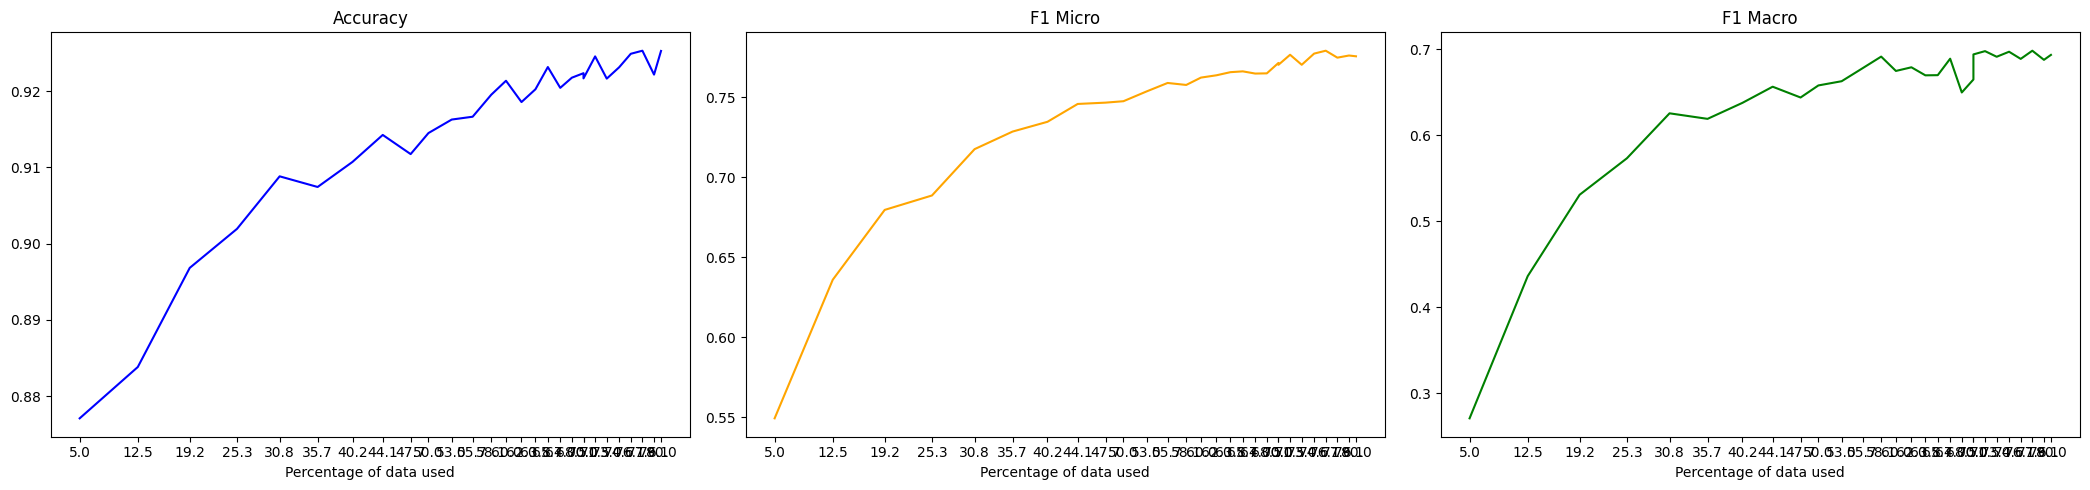

In [23]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5799, Accuracy: 0.8262, F1 Micro: 0.3921, F1 Macro: 0.1031
Epoch 2/10, Train Loss: 0.4517, Accuracy: 0.8344, F1 Micro: 0.1933, F1 Macro: 0.0512
Epoch 3/10, Train Loss: 0.4051, Accuracy: 0.8316, F1 Micro: 0.068, F1 Macro: 0.0274
Epoch 4/10, Train Loss: 0.3657, Accuracy: 0.8368, F1 Micro: 0.146, F1 Macro: 0.049
Epoch 5/10, Train Loss: 0.3619, Accuracy: 0.8459, F1 Micro: 0.2447, F1 Macro: 0.086
Epoch 6/10, Train Loss: 0.3378, Accuracy: 0.8532, F1 Micro: 0.3418, F1 Macro: 0.1265
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3201, Accuracy: 0.8684, F1 Micro: 0.5, F1 Macro: 0.2319
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3026, Accuracy: 0.8717, F1 Micro: 0.5243, F1 Macro: 0.246
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2623, Accuracy: 0.8734, F1 Micro: 0.5965, F1 Macro: 0.2782
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2681, Accuracy: 0.875, F1 Micro: 0.6017, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4712, Accuracy: 0.8278, F1 Micro: 0.0004, F1 Macro: 0.0001
Epoch 2/10, Train Loss: 0.3012, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2678, Accuracy: 0.8282, F1 Micro: 0.005, F1 Macro: 0.0023
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2334, Accuracy: 0.8462, F1 Micro: 0.2413, F1 Macro: 0.0825
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2139, Accuracy: 0.8696, F1 Micro: 0.5548, F1 Macro: 0.2565
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1827, Accuracy: 0.8758, F1 Micro: 0.5672, F1 Macro: 0.2643
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1782, Accuracy: 0.8771, F1 Micro: 0.5919, F1 Macro: 0.2821
Epoch 8/10, Train Loss: 0.1616, Accuracy: 0.878, F1 Micro: 0.5526, F1 Macro: 0.2771
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1455, Accuracy: 0.8789, F1 Micro: 0.6115, F1 Macro: 0.3223
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4851, Accuracy: 0.8426, F1 Micro: 0.3353, F1 Macro: 0.094
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3423, Accuracy: 0.866, F1 Micro: 0.5684, F1 Macro: 0.2617
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.285, Accuracy: 0.8811, F1 Micro: 0.5955, F1 Macro: 0.3238
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2516, Accuracy: 0.8894, F1 Micro: 0.6216, F1 Macro: 0.3875
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2153, Accuracy: 0.8945, F1 Micro: 0.6709, F1 Macro: 0.482
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1921, Accuracy: 0.8978, F1 Micro: 0.685, F1 Macro: 0.5126
Epoch 7/10, Train Loss: 0.1759, Accuracy: 0.8968, F1 Micro: 0.6524, F1 Macro: 0.4949
Epoch 8/10, Train Loss: 0.1487, Accuracy: 0.8971, F1 Micro: 0.662, F1 Macro: 0.4935
Epoch 9/10, Train Loss: 0.132, Accuracy: 0.8983, F1 Micro: 0.6596, F1 Macro: 0.5239
Epoch 10/10, Train Loss: 0.1158, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4398, Accuracy: 0.8412, F1 Micro: 0.1992, F1 Macro: 0.0648
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.298, Accuracy: 0.8738, F1 Micro: 0.5062, F1 Macro: 0.2303
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.238, Accuracy: 0.8879, F1 Micro: 0.624, F1 Macro: 0.3694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1983, Accuracy: 0.8929, F1 Micro: 0.6277, F1 Macro: 0.4535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1672, Accuracy: 0.8971, F1 Micro: 0.6799, F1 Macro: 0.5113
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1572, Accuracy: 0.9005, F1 Micro: 0.6862, F1 Macro: 0.5329
Epoch 7/10, Train Loss: 0.1275, Accuracy: 0.9006, F1 Micro: 0.6818, F1 Macro: 0.5376
Epoch 8/10, Train Loss: 0.1092, Accuracy: 0.8997, F1 Micro: 0.6594, F1 Macro: 0.517
Epoch 9/10, Train Loss: 0.0991, Accuracy: 0.8992, F1 Micro: 0.6688, F1 Macro: 0.5267
Epoch 10/10, Train Loss: 0.0806, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4408, Accuracy: 0.8588, F1 Micro: 0.4793, F1 Macro: 0.2057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.294, Accuracy: 0.8836, F1 Micro: 0.6026, F1 Macro: 0.3283
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2361, Accuracy: 0.8926, F1 Micro: 0.616, F1 Macro: 0.3993
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2072, Accuracy: 0.9, F1 Micro: 0.656, F1 Macro: 0.5013
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1711, Accuracy: 0.9026, F1 Micro: 0.6867, F1 Macro: 0.5165
Epoch 6/10, Train Loss: 0.1483, Accuracy: 0.9043, F1 Micro: 0.6857, F1 Macro: 0.5503
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1316, Accuracy: 0.9067, F1 Micro: 0.7178, F1 Macro: 0.574
Epoch 8/10, Train Loss: 0.1096, Accuracy: 0.9039, F1 Micro: 0.6919, F1 Macro: 0.5609
Epoch 9/10, Train Loss: 0.0953, Accuracy: 0.9019, F1 Micro: 0.7168, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4327, Accuracy: 0.8665, F1 Micro: 0.5115, F1 Macro: 0.22
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2913, Accuracy: 0.889, F1 Micro: 0.6397, F1 Macro: 0.3676
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.235, Accuracy: 0.8984, F1 Micro: 0.6938, F1 Macro: 0.5229
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1982, Accuracy: 0.9008, F1 Micro: 0.7074, F1 Macro: 0.5495
Epoch 5/10, Train Loss: 0.1741, Accuracy: 0.9068, F1 Micro: 0.7021, F1 Macro: 0.5441
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1482, Accuracy: 0.9039, F1 Micro: 0.7151, F1 Macro: 0.5588
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1261, Accuracy: 0.9089, F1 Micro: 0.7167, F1 Macro: 0.5805
Epoch 8/10, Train Loss: 0.1099, Accuracy: 0.9082, F1 Micro: 0.713, F1 Macro: 0.6055
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0962, Accuracy: 0.9063, F1 Micro: 0.7299, F1 Macro: 0.6198
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4283, Accuracy: 0.8699, F1 Micro: 0.5728, F1 Macro: 0.262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2876, Accuracy: 0.892, F1 Micro: 0.6526, F1 Macro: 0.3967
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2294, Accuracy: 0.9003, F1 Micro: 0.6728, F1 Macro: 0.5065
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1938, Accuracy: 0.9041, F1 Micro: 0.727, F1 Macro: 0.5753
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1669, Accuracy: 0.911, F1 Micro: 0.7291, F1 Macro: 0.5758
Epoch 6/10, Train Loss: 0.1389, Accuracy: 0.9115, F1 Micro: 0.724, F1 Macro: 0.6027
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1217, Accuracy: 0.912, F1 Micro: 0.7403, F1 Macro: 0.6285
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1051, Accuracy: 0.9127, F1 Micro: 0.7431, F1 Macro: 0.6445
Epoch 9/10, Train Loss: 0.0896, Accuracy: 0.9122, F1 Micro: 0.7376, F1 Macro: 0.6398
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4183, Accuracy: 0.8776, F1 Micro: 0.5813, F1 Macro: 0.2699
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2771, Accuracy: 0.8931, F1 Micro: 0.683, F1 Macro: 0.4338
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2242, Accuracy: 0.9052, F1 Micro: 0.7032, F1 Macro: 0.5159
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1881, Accuracy: 0.9107, F1 Micro: 0.7296, F1 Macro: 0.5738
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1614, Accuracy: 0.9135, F1 Micro: 0.7345, F1 Macro: 0.589
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.911, F1 Micro: 0.7411, F1 Macro: 0.615
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1156, Accuracy: 0.9108, F1 Micro: 0.7446, F1 Macro: 0.6269
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0994, Accuracy: 0.9166, F1 Micro: 0.7478, F1 Macro: 0.6439
Epoch 9/10, Train Loss: 0.085, Accuracy: 0.9164, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4024, Accuracy: 0.8716, F1 Micro: 0.4631, F1 Macro: 0.2125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.8979, F1 Micro: 0.6603, F1 Macro: 0.4339
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2167, Accuracy: 0.907, F1 Micro: 0.7138, F1 Macro: 0.5604
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1778, Accuracy: 0.9102, F1 Micro: 0.7361, F1 Macro: 0.5877
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1495, Accuracy: 0.9089, F1 Micro: 0.7405, F1 Macro: 0.5932
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1263, Accuracy: 0.9137, F1 Micro: 0.7445, F1 Macro: 0.6216
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1096, Accuracy: 0.915, F1 Micro: 0.752, F1 Macro: 0.633
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.9129, F1 Micro: 0.7468, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0822, Accuracy: 0.9142, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3972, Accuracy: 0.8798, F1 Micro: 0.5901, F1 Macro: 0.2831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2578, Accuracy: 0.8995, F1 Micro: 0.6965, F1 Macro: 0.4801
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2065, Accuracy: 0.9084, F1 Micro: 0.7153, F1 Macro: 0.5392
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.9133, F1 Micro: 0.738, F1 Macro: 0.5821
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9146, F1 Micro: 0.7467, F1 Macro: 0.61
Epoch 6/10, Train Loss: 0.1271, Accuracy: 0.9143, F1 Micro: 0.7443, F1 Macro: 0.62
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1064, Accuracy: 0.9169, F1 Micro: 0.7478, F1 Macro: 0.6351
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0933, Accuracy: 0.9131, F1 Micro: 0.7496, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9186, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4002, Accuracy: 0.8816, F1 Micro: 0.5905, F1 Macro: 0.2786
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2687, Accuracy: 0.8995, F1 Micro: 0.7009, F1 Macro: 0.5101
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.211, Accuracy: 0.9081, F1 Micro: 0.7126, F1 Macro: 0.5311
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1805, Accuracy: 0.9102, F1 Micro: 0.7395, F1 Macro: 0.5747
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9137, F1 Micro: 0.7474, F1 Macro: 0.6014
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1298, Accuracy: 0.9169, F1 Micro: 0.7504, F1 Macro: 0.6568
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1074, Accuracy: 0.9171, F1 Micro: 0.7514, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0914, Accuracy: 0.9191, F1 Micro: 0.7598, F1 Macro: 0.6782
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9165, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.393, Accuracy: 0.8828, F1 Micro: 0.595, F1 Macro: 0.2801
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2607, Accuracy: 0.899, F1 Micro: 0.707, F1 Macro: 0.5095
Epoch 3/10, Train Loss: 0.2086, Accuracy: 0.9081, F1 Micro: 0.6947, F1 Macro: 0.4941
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1755, Accuracy: 0.9157, F1 Micro: 0.7354, F1 Macro: 0.5763
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.9182, F1 Micro: 0.7425, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1259, Accuracy: 0.9194, F1 Micro: 0.7621, F1 Macro: 0.6574
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.9186, F1 Micro: 0.7617, F1 Macro: 0.6773
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9194, F1 Micro: 0.7579, F1 Macro: 0.6699
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.9214, F1 Micro: 0.7614, F1 Macro: 0.6878
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0668, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3921, Accuracy: 0.8787, F1 Micro: 0.5295, F1 Macro: 0.2504
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2577, Accuracy: 0.9001, F1 Micro: 0.6959, F1 Macro: 0.4797
Epoch 3/10, Train Loss: 0.2052, Accuracy: 0.9074, F1 Micro: 0.6859, F1 Macro: 0.4972
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1724, Accuracy: 0.915, F1 Micro: 0.7311, F1 Macro: 0.5758
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1499, Accuracy: 0.916, F1 Micro: 0.7547, F1 Macro: 0.6274
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1276, Accuracy: 0.9178, F1 Micro: 0.7555, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9192, F1 Micro: 0.764, F1 Macro: 0.6736
Epoch 8/10, Train Loss: 0.0852, Accuracy: 0.916, F1 Micro: 0.7606, F1 Macro: 0.6829
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.9192, F1 Micro: 0.769, F1 Macro: 0.6954
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3906, Accuracy: 0.8821, F1 Micro: 0.6018, F1 Macro: 0.2903
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2582, Accuracy: 0.903, F1 Micro: 0.7052, F1 Macro: 0.4914
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.211, Accuracy: 0.9116, F1 Micro: 0.7231, F1 Macro: 0.5454
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9155, F1 Micro: 0.74, F1 Macro: 0.5775
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9152, F1 Micro: 0.7518, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1244, Accuracy: 0.9169, F1 Micro: 0.7547, F1 Macro: 0.6603
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1065, Accuracy: 0.9214, F1 Micro: 0.7559, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0914, Accuracy: 0.9199, F1 Micro: 0.7603, F1 Macro: 0.6783
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.077

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3882, Accuracy: 0.8836, F1 Micro: 0.6236, F1 Macro: 0.3134
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.9026, F1 Micro: 0.7013, F1 Macro: 0.5254
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9108, F1 Micro: 0.7288, F1 Macro: 0.5597
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9162, F1 Micro: 0.7483, F1 Macro: 0.5993
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1438, Accuracy: 0.9165, F1 Micro: 0.7577, F1 Macro: 0.6303
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1189, Accuracy: 0.9205, F1 Micro: 0.7586, F1 Macro: 0.6451
Epoch 7/10, Train Loss: 0.1049, Accuracy: 0.92, F1 Micro: 0.757, F1 Macro: 0.6462
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0878, Accuracy: 0.918, F1 Micro: 0.7611, F1 Macro: 0.6661
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.92, F1 Micro: 0.7601, F1 Macro: 0.667
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3897, Accuracy: 0.8846, F1 Micro: 0.5896, F1 Macro: 0.2915
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2585, Accuracy: 0.9023, F1 Micro: 0.7023, F1 Macro: 0.4551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2088, Accuracy: 0.9115, F1 Micro: 0.7389, F1 Macro: 0.5839
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.9176, F1 Micro: 0.7481, F1 Macro: 0.5937
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9127, F1 Micro: 0.7536, F1 Macro: 0.6293
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.9185, F1 Micro: 0.7639, F1 Macro: 0.6498
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.92, F1 Micro: 0.7704, F1 Macro: 0.6753
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9196, F1 Micro: 0.7648, F1 Macro: 0.6751
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.9203, F1 Micro: 0.77, F1 Macro: 0.6901
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3809, Accuracy: 0.884, F1 Micro: 0.6407, F1 Macro: 0.3236
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2581, Accuracy: 0.9052, F1 Micro: 0.7005, F1 Macro: 0.494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2046, Accuracy: 0.9103, F1 Micro: 0.7324, F1 Macro: 0.5623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.9139, F1 Micro: 0.753, F1 Macro: 0.6015
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1435, Accuracy: 0.9208, F1 Micro: 0.7612, F1 Macro: 0.6398
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1248, Accuracy: 0.919, F1 Micro: 0.7626, F1 Macro: 0.6327
Epoch 7/10, Train Loss: 0.1025, Accuracy: 0.9209, F1 Micro: 0.7622, F1 Macro: 0.6557
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9207, F1 Micro: 0.7655, F1 Macro: 0.6716
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0792, Accuracy: 0.9234, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3773, Accuracy: 0.8858, F1 Micro: 0.6201, F1 Macro: 0.3085
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.252, Accuracy: 0.9036, F1 Micro: 0.708, F1 Macro: 0.5086
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9143, F1 Micro: 0.7417, F1 Macro: 0.5764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9173, F1 Micro: 0.7556, F1 Macro: 0.6057
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.9194, F1 Micro: 0.7594, F1 Macro: 0.617
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9169, F1 Micro: 0.7608, F1 Macro: 0.644
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.92, F1 Micro: 0.7673, F1 Macro: 0.6657
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9212, F1 Micro: 0.7577, F1 Macro: 0.6722
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9195, F1 Micro: 0.764, F1 Macro: 0.6735
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3777, Accuracy: 0.8881, F1 Micro: 0.6268, F1 Macro: 0.3234
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.252, Accuracy: 0.9063, F1 Micro: 0.7149, F1 Macro: 0.5293
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.205, Accuracy: 0.9093, F1 Micro: 0.7335, F1 Macro: 0.5543
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9137, F1 Micro: 0.7496, F1 Macro: 0.6065
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.92, F1 Micro: 0.7488, F1 Macro: 0.6087
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1222, Accuracy: 0.922, F1 Micro: 0.7653, F1 Macro: 0.6611
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9197, F1 Micro: 0.7661, F1 Macro: 0.6698
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9211, F1 Micro: 0.7653, F1 Macro: 0.6689
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.9207, F1 Micro: 0.7626, F1 Macro: 0.6758
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3799, Accuracy: 0.883, F1 Micro: 0.5656, F1 Macro: 0.2846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2513, Accuracy: 0.907, F1 Micro: 0.7014, F1 Macro: 0.5162
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2075, Accuracy: 0.9127, F1 Micro: 0.7386, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1712, Accuracy: 0.9185, F1 Micro: 0.7532, F1 Macro: 0.5911
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1443, Accuracy: 0.9201, F1 Micro: 0.7586, F1 Macro: 0.6123
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.119, Accuracy: 0.921, F1 Micro: 0.7691, F1 Macro: 0.6556
Epoch 7/10, Train Loss: 0.0993, Accuracy: 0.9209, F1 Micro: 0.7667, F1 Macro: 0.672
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9194, F1 Micro: 0.7716, F1 Macro: 0.6744
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9206, F1 Micro: 0.7654, F1 Macro: 0.68
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3747, Accuracy: 0.8857, F1 Micro: 0.5998, F1 Macro: 0.3045
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2506, Accuracy: 0.9037, F1 Micro: 0.7186, F1 Macro: 0.5385
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1999, Accuracy: 0.9135, F1 Micro: 0.7354, F1 Macro: 0.5621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1687, Accuracy: 0.92, F1 Micro: 0.7615, F1 Macro: 0.6158
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.9199, F1 Micro: 0.7599, F1 Macro: 0.6446
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9211, F1 Micro: 0.7656, F1 Macro: 0.6523
Epoch 7/10, Train Loss: 0.1011, Accuracy: 0.9231, F1 Micro: 0.7614, F1 Macro: 0.6255
Epoch 8/10, Train Loss: 0.0826, Accuracy: 0.9215, F1 Micro: 0.7656, F1 Macro: 0.6741
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.9223, F1 Micro: 0.7659, F1 Macro: 0.6817
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3772, Accuracy: 0.8872, F1 Micro: 0.6157, F1 Macro: 0.3107
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.251, Accuracy: 0.9054, F1 Micro: 0.7197, F1 Macro: 0.5258
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.9157, F1 Micro: 0.739, F1 Macro: 0.5736
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.916, F1 Micro: 0.7627, F1 Macro: 0.6158
Epoch 5/10, Train Loss: 0.145, Accuracy: 0.9141, F1 Micro: 0.7612, F1 Macro: 0.6409
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1228, Accuracy: 0.9191, F1 Micro: 0.7703, F1 Macro: 0.6693
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1015, Accuracy: 0.9231, F1 Micro: 0.7709, F1 Macro: 0.6639
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9236, F1 Micro: 0.7721, F1 Macro: 0.6695
Epoch 9/10, Train Loss: 0.0733, Accuracy: 0.9245, F1 Micro: 0.7713, F1 Macro: 0.6738
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3755, Accuracy: 0.8876, F1 Micro: 0.6112, F1 Macro: 0.3231
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2468, Accuracy: 0.9063, F1 Micro: 0.6841, F1 Macro: 0.5065
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2012, Accuracy: 0.9152, F1 Micro: 0.7291, F1 Macro: 0.5751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.9205, F1 Micro: 0.7623, F1 Macro: 0.6146
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9172, F1 Micro: 0.7675, F1 Macro: 0.6325
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9212, F1 Micro: 0.7713, F1 Macro: 0.6683
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9218, F1 Micro: 0.77, F1 Macro: 0.6625
Epoch 8/10, Train Loss: 0.0882, Accuracy: 0.9184, F1 Micro: 0.7677, F1 Macro: 0.6684
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9227, F1 Micro: 0.7707, F1 Macro: 0.6819
Epoch 10/10, Train Loss: 0.062, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3733, Accuracy: 0.8881, F1 Micro: 0.6271, F1 Macro: 0.3387
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2521, Accuracy: 0.9057, F1 Micro: 0.7255, F1 Macro: 0.5568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.9152, F1 Micro: 0.7427, F1 Macro: 0.5642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9184, F1 Micro: 0.7465, F1 Macro: 0.5809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.9216, F1 Micro: 0.7476, F1 Macro: 0.6245
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.9236, F1 Micro: 0.7681, F1 Macro: 0.6631
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9225, F1 Micro: 0.7734, F1 Macro: 0.6826
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9226, F1 Micro: 0.7603, F1 Macro: 0.675
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9224, F1 Micro: 0.7709, F1 Macro: 0.684
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3706, Accuracy: 0.887, F1 Micro: 0.5907, F1 Macro: 0.2954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2419, Accuracy: 0.9017, F1 Micro: 0.722, F1 Macro: 0.5398
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2004, Accuracy: 0.9177, F1 Micro: 0.7393, F1 Macro: 0.5757
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9157, F1 Micro: 0.7605, F1 Macro: 0.6038
Epoch 5/10, Train Loss: 0.1465, Accuracy: 0.9138, F1 Micro: 0.7598, F1 Macro: 0.6459
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.9208, F1 Micro: 0.7731, F1 Macro: 0.6658
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9228, F1 Micro: 0.7738, F1 Macro: 0.6758
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9241, F1 Micro: 0.7726, F1 Macro: 0.6733
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.9231, F1 Micro: 0.767, F1 Macro: 0.6882
Epoch 10/10, Train Loss: 0.0614, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3649, Accuracy: 0.8898, F1 Micro: 0.622, F1 Macro: 0.3145
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2485, Accuracy: 0.9083, F1 Micro: 0.7175, F1 Macro: 0.4974
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2008, Accuracy: 0.9157, F1 Micro: 0.7295, F1 Macro: 0.5411
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9196, F1 Micro: 0.7629, F1 Macro: 0.615
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9221, F1 Micro: 0.7588, F1 Macro: 0.643
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9206, F1 Micro: 0.7714, F1 Macro: 0.6625
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.099, Accuracy: 0.9212, F1 Micro: 0.773, F1 Macro: 0.6693
Epoch 8/10, Train Loss: 0.0862, Accuracy: 0.9175, F1 Micro: 0.7704, F1 Macro: 0.6702
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9239, F1 Micro: 0.7714, F1 Macro: 0.6802
Epoch 10/10, Train Loss: 0.06, Accuracy: 0.92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3682, Accuracy: 0.8904, F1 Micro: 0.6466, F1 Macro: 0.3398
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2463, Accuracy: 0.91, F1 Micro: 0.7199, F1 Macro: 0.5327
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.917, F1 Micro: 0.7491, F1 Macro: 0.5907
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1653, Accuracy: 0.9212, F1 Micro: 0.7688, F1 Macro: 0.6142
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1401, Accuracy: 0.9231, F1 Micro: 0.7731, F1 Macro: 0.6299
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9222, F1 Micro: 0.77, F1 Macro: 0.6417
Epoch 7/10, Train Loss: 0.0999, Accuracy: 0.9209, F1 Micro: 0.7715, F1 Macro: 0.6656
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.9234, F1 Micro: 0.7752, F1 Macro: 0.6828
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0709, Accuracy: 0.9254, F1 Micro: 0.7759, F1 Macro: 0.6987
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3711, Accuracy: 0.8894, F1 Micro: 0.6088, F1 Macro: 0.3175
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2512, Accuracy: 0.9069, F1 Micro: 0.6886, F1 Macro: 0.4934
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2015, Accuracy: 0.9173, F1 Micro: 0.7368, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1677, Accuracy: 0.9219, F1 Micro: 0.7648, F1 Macro: 0.6223
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9184, F1 Micro: 0.7665, F1 Macro: 0.6305
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9243, F1 Micro: 0.7776, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.926, F1 Micro: 0.7786, F1 Macro: 0.6836
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.9232, F1 Micro: 0.7762, F1 Macro: 0.6692
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.9258, F1 Micro: 0.7785, F1 Macro: 0.6893
Epoch

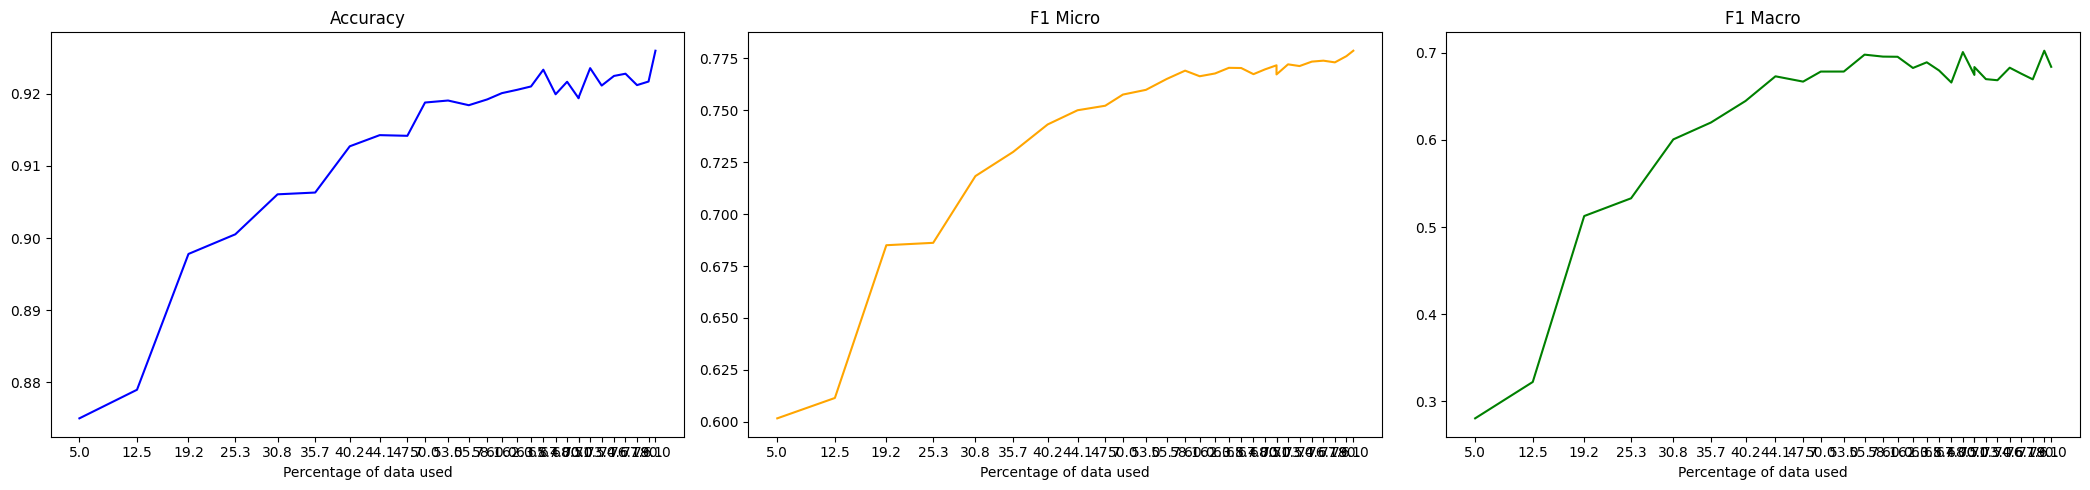

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5976, Accuracy: 0.8313, F1 Micro: 0.2023, F1 Macro: 0.0526
Epoch 2/10, Train Loss: 0.4529, Accuracy: 0.8295, F1 Micro: 0.0511, F1 Macro: 0.0184
Epoch 3/10, Train Loss: 0.425, Accuracy: 0.8349, F1 Micro: 0.1135, F1 Macro: 0.0445
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3847, Accuracy: 0.847, F1 Micro: 0.2733, F1 Macro: 0.0921
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.379, Accuracy: 0.8488, F1 Micro: 0.2963, F1 Macro: 0.0979
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3536, Accuracy: 0.8566, F1 Micro: 0.4128, F1 Macro: 0.1411
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.346, Accuracy: 0.8661, F1 Micro: 0.448, F1 Macro: 0.1925
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3125, Accuracy: 0.87, F1 Micro: 0.5757, F1 Macro: 0.2665
Epoch 9/10, Train Loss: 0.3022, Accuracy: 0.8743, F1 Micro: 0.5694, F1 Macro: 0.2653
Epoch 10/10, Train Loss: 0.2677, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4841, Accuracy: 0.8278, F1 Micro: 0.0004, F1 Macro: 0.0001
Epoch 2/10, Train Loss: 0.3346, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3035, Accuracy: 0.8491, F1 Micro: 0.3058, F1 Macro: 0.0993
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2654, Accuracy: 0.8684, F1 Micro: 0.5247, F1 Macro: 0.245
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2331, Accuracy: 0.875, F1 Micro: 0.5399, F1 Macro: 0.2745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2006, Accuracy: 0.879, F1 Micro: 0.6142, F1 Macro: 0.3284
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1898, Accuracy: 0.8822, F1 Micro: 0.6233, F1 Macro: 0.3593
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1716, Accuracy: 0.8884, F1 Micro: 0.6362, F1 Macro: 0.4327
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1516, Accuracy: 0.8891, F1 Micro: 0.655

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5008, Accuracy: 0.8375, F1 Micro: 0.3917, F1 Macro: 0.1085
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3591, Accuracy: 0.8645, F1 Micro: 0.494, F1 Macro: 0.2357
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3078, Accuracy: 0.8743, F1 Micro: 0.6023, F1 Macro: 0.3669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2683, Accuracy: 0.8886, F1 Micro: 0.6216, F1 Macro: 0.4613
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2373, Accuracy: 0.8937, F1 Micro: 0.634, F1 Macro: 0.4418
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2162, Accuracy: 0.9008, F1 Micro: 0.6897, F1 Macro: 0.5367
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.19, Accuracy: 0.8986, F1 Micro: 0.7069, F1 Macro: 0.5595
Epoch 8/10, Train Loss: 0.1686, Accuracy: 0.9039, F1 Micro: 0.7002, F1 Macro: 0.5607
Epoch 9/10, Train Loss: 0.14, Accuracy: 0.9012, F1 Micro: 0.7051, F1 Macro: 0.5691
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4727, Accuracy: 0.846, F1 Micro: 0.4189, F1 Macro: 0.1355
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.341, Accuracy: 0.8752, F1 Micro: 0.6095, F1 Macro: 0.3803
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.285, Accuracy: 0.8904, F1 Micro: 0.6791, F1 Macro: 0.4694
Epoch 4/10, Train Loss: 0.2483, Accuracy: 0.8999, F1 Micro: 0.6736, F1 Macro: 0.4761
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2168, Accuracy: 0.9039, F1 Micro: 0.694, F1 Macro: 0.5218
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1875, Accuracy: 0.9032, F1 Micro: 0.7141, F1 Macro: 0.5561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1617, Accuracy: 0.9038, F1 Micro: 0.7195, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1394, Accuracy: 0.9039, F1 Micro: 0.72, F1 Macro: 0.5747
Epoch 9/10, Train Loss: 0.1235, Accuracy: 0.9071, F1 Micro: 0.7133, F1 Macro: 0.5819
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4703, Accuracy: 0.8455, F1 Micro: 0.4927, F1 Macro: 0.2013
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.344, Accuracy: 0.8874, F1 Micro: 0.6319, F1 Macro: 0.4105
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2807, Accuracy: 0.8986, F1 Micro: 0.6951, F1 Macro: 0.536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2341, Accuracy: 0.9001, F1 Micro: 0.7135, F1 Macro: 0.5687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2085, Accuracy: 0.9092, F1 Micro: 0.7241, F1 Macro: 0.5761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1682, Accuracy: 0.9122, F1 Micro: 0.7296, F1 Macro: 0.5942
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1499, Accuracy: 0.9079, F1 Micro: 0.7308, F1 Macro: 0.59
Epoch 8/10, Train Loss: 0.1352, Accuracy: 0.9095, F1 Micro: 0.727, F1 Macro: 0.589
Epoch 9/10, Train Loss: 0.1187, Accuracy: 0.9071, F1 Micro: 0.7168, F1 Macro: 0.5968
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4631, Accuracy: 0.8521, F1 Micro: 0.5377, F1 Macro: 0.2547
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3389, Accuracy: 0.8903, F1 Micro: 0.6309, F1 Macro: 0.3995
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2782, Accuracy: 0.8977, F1 Micro: 0.6799, F1 Macro: 0.5321
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2343, Accuracy: 0.9078, F1 Micro: 0.7041, F1 Macro: 0.5586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2048, Accuracy: 0.9072, F1 Micro: 0.7303, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1758, Accuracy: 0.9122, F1 Micro: 0.736, F1 Macro: 0.6278
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1542, Accuracy: 0.9137, F1 Micro: 0.7395, F1 Macro: 0.6384
Epoch 8/10, Train Loss: 0.1325, Accuracy: 0.9103, F1 Micro: 0.7339, F1 Macro: 0.6487
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1098, Accuracy: 0.9104, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4426, Accuracy: 0.8685, F1 Micro: 0.5347, F1 Macro: 0.2551
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3099, Accuracy: 0.8921, F1 Micro: 0.639, F1 Macro: 0.4695
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2569, Accuracy: 0.9029, F1 Micro: 0.6929, F1 Macro: 0.55
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2129, Accuracy: 0.9075, F1 Micro: 0.7209, F1 Macro: 0.5801
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1833, Accuracy: 0.9114, F1 Micro: 0.7415, F1 Macro: 0.6089
Epoch 6/10, Train Loss: 0.1606, Accuracy: 0.9109, F1 Micro: 0.7335, F1 Macro: 0.6308
Epoch 7/10, Train Loss: 0.1377, Accuracy: 0.9127, F1 Micro: 0.7367, F1 Macro: 0.6337
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1155, Accuracy: 0.9139, F1 Micro: 0.7422, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1023, Accuracy: 0.9131, F1 Micro: 0.7438, F1 Macro: 0.6494
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4306, Accuracy: 0.8689, F1 Micro: 0.5775, F1 Macro: 0.2862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3009, Accuracy: 0.8931, F1 Micro: 0.6876, F1 Macro: 0.4995
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2433, Accuracy: 0.9068, F1 Micro: 0.7152, F1 Macro: 0.5495
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2032, Accuracy: 0.9124, F1 Micro: 0.7155, F1 Macro: 0.5629
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1737, Accuracy: 0.9147, F1 Micro: 0.7468, F1 Macro: 0.6226
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1496, Accuracy: 0.9126, F1 Micro: 0.7508, F1 Macro: 0.6509
Epoch 7/10, Train Loss: 0.1303, Accuracy: 0.916, F1 Micro: 0.7431, F1 Macro: 0.6579
Epoch 8/10, Train Loss: 0.1129, Accuracy: 0.9135, F1 Micro: 0.7435, F1 Macro: 0.6697
Epoch 9/10, Train Loss: 0.0919, Accuracy: 0.9138, F1 Micro: 0.7502, F1 Macro: 0.6785
Epoch 10/10, Train Loss: 0.0868, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4251, Accuracy: 0.8748, F1 Micro: 0.6127, F1 Macro: 0.3084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2965, Accuracy: 0.8996, F1 Micro: 0.685, F1 Macro: 0.4741
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2424, Accuracy: 0.9086, F1 Micro: 0.7181, F1 Macro: 0.5483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1986, Accuracy: 0.9119, F1 Micro: 0.7274, F1 Macro: 0.5798
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1697, Accuracy: 0.9152, F1 Micro: 0.748, F1 Macro: 0.6304
Epoch 6/10, Train Loss: 0.1467, Accuracy: 0.9171, F1 Micro: 0.7408, F1 Macro: 0.6447
Epoch 7/10, Train Loss: 0.122, Accuracy: 0.9112, F1 Micro: 0.7463, F1 Macro: 0.6413
Epoch 8/10, Train Loss: 0.1073, Accuracy: 0.9159, F1 Micro: 0.7443, F1 Macro: 0.6556
Epoch 9/10, Train Loss: 0.0936, Accuracy: 0.911, F1 Micro: 0.7455, F1 Macro: 0.6616
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0812, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4171, Accuracy: 0.8786, F1 Micro: 0.5625, F1 Macro: 0.2801
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2915, Accuracy: 0.9005, F1 Micro: 0.6803, F1 Macro: 0.4735
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2356, Accuracy: 0.9066, F1 Micro: 0.7199, F1 Macro: 0.554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2037, Accuracy: 0.9148, F1 Micro: 0.7353, F1 Macro: 0.5829
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1693, Accuracy: 0.9116, F1 Micro: 0.7525, F1 Macro: 0.6467
Epoch 6/10, Train Loss: 0.1424, Accuracy: 0.9171, F1 Micro: 0.7483, F1 Macro: 0.6425
Epoch 7/10, Train Loss: 0.1199, Accuracy: 0.9113, F1 Micro: 0.7496, F1 Macro: 0.6435
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1044, Accuracy: 0.9198, F1 Micro: 0.7597, F1 Macro: 0.6715
Epoch 9/10, Train Loss: 0.0905, Accuracy: 0.9169, F1 Micro: 0.7531, F1 Macro: 0.6639
Epoch 10/10, Train Loss: 0.0779, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4166, Accuracy: 0.8777, F1 Micro: 0.6228, F1 Macro: 0.3189
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2866, Accuracy: 0.9023, F1 Micro: 0.6926, F1 Macro: 0.4988
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.225, Accuracy: 0.9111, F1 Micro: 0.7268, F1 Macro: 0.5656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1942, Accuracy: 0.9077, F1 Micro: 0.7409, F1 Macro: 0.587
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1599, Accuracy: 0.918, F1 Micro: 0.7503, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1377, Accuracy: 0.9192, F1 Micro: 0.7609, F1 Macro: 0.658
Epoch 7/10, Train Loss: 0.1178, Accuracy: 0.919, F1 Micro: 0.7592, F1 Macro: 0.6765
Epoch 8/10, Train Loss: 0.1007, Accuracy: 0.9153, F1 Micro: 0.7548, F1 Macro: 0.6678
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0872, Accuracy: 0.9218, F1 Micro: 0.7617, F1 Macro: 0.685
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4045, Accuracy: 0.8786, F1 Micro: 0.626, F1 Macro: 0.3198
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2811, Accuracy: 0.899, F1 Micro: 0.6965, F1 Macro: 0.4695
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2281, Accuracy: 0.9113, F1 Micro: 0.7259, F1 Macro: 0.5543
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1914, Accuracy: 0.9162, F1 Micro: 0.7409, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1587, Accuracy: 0.9144, F1 Micro: 0.7539, F1 Macro: 0.6258
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1344, Accuracy: 0.9168, F1 Micro: 0.755, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1186, Accuracy: 0.9168, F1 Micro: 0.7594, F1 Macro: 0.6603
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.9196, F1 Micro: 0.759, F1 Macro: 0.6566
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0841, Accuracy: 0.9212, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.408, Accuracy: 0.8819, F1 Micro: 0.582, F1 Macro: 0.2931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2758, Accuracy: 0.9006, F1 Micro: 0.701, F1 Macro: 0.5332
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2328, Accuracy: 0.9107, F1 Micro: 0.7321, F1 Macro: 0.5538
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1897, Accuracy: 0.9161, F1 Micro: 0.7404, F1 Macro: 0.5934
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1611, Accuracy: 0.9191, F1 Micro: 0.7601, F1 Macro: 0.6326
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1342, Accuracy: 0.9192, F1 Micro: 0.7644, F1 Macro: 0.6477
Epoch 7/10, Train Loss: 0.1146, Accuracy: 0.9159, F1 Micro: 0.759, F1 Macro: 0.6769
Epoch 8/10, Train Loss: 0.0978, Accuracy: 0.916, F1 Micro: 0.7587, F1 Macro: 0.6612
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0859, Accuracy: 0.9214, F1 Micro: 0.7674, F1 Macro: 0.6936
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4002, Accuracy: 0.8824, F1 Micro: 0.6237, F1 Macro: 0.3181
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.273, Accuracy: 0.9017, F1 Micro: 0.7106, F1 Macro: 0.5226
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2194, Accuracy: 0.9101, F1 Micro: 0.7362, F1 Macro: 0.5647
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.186, Accuracy: 0.9172, F1 Micro: 0.7399, F1 Macro: 0.583
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1569, Accuracy: 0.9132, F1 Micro: 0.7554, F1 Macro: 0.627
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1354, Accuracy: 0.9195, F1 Micro: 0.7573, F1 Macro: 0.6499
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.109, Accuracy: 0.9197, F1 Micro: 0.7625, F1 Macro: 0.6663
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.9205, F1 Micro: 0.7599, F1 Macro: 0.6751
Epoch 9/10, Train Loss: 0.0851, Accuracy: 0.9204, F1 Micro: 0.7578, F1 Macro: 0.6869
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3987, Accuracy: 0.8815, F1 Micro: 0.5712, F1 Macro: 0.2746
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.273, Accuracy: 0.9037, F1 Micro: 0.6792, F1 Macro: 0.4715
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2201, Accuracy: 0.9121, F1 Micro: 0.7231, F1 Macro: 0.5593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1809, Accuracy: 0.9153, F1 Micro: 0.7507, F1 Macro: 0.5922
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.155, Accuracy: 0.9205, F1 Micro: 0.7527, F1 Macro: 0.624
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1301, Accuracy: 0.9186, F1 Micro: 0.7628, F1 Macro: 0.6614
Epoch 7/10, Train Loss: 0.1098, Accuracy: 0.9199, F1 Micro: 0.761, F1 Macro: 0.6669
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0945, Accuracy: 0.9211, F1 Micro: 0.7644, F1 Macro: 0.6757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.9205, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3954, Accuracy: 0.8835, F1 Micro: 0.6044, F1 Macro: 0.2948
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2676, Accuracy: 0.9016, F1 Micro: 0.7156, F1 Macro: 0.5281
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.9099, F1 Micro: 0.7292, F1 Macro: 0.5628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1832, Accuracy: 0.918, F1 Micro: 0.7405, F1 Macro: 0.5941
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.9127, F1 Micro: 0.759, F1 Macro: 0.639
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9216, F1 Micro: 0.7578, F1 Macro: 0.6631
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1138, Accuracy: 0.9231, F1 Micro: 0.772, F1 Macro: 0.6882
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0912, Accuracy: 0.9224, F1 Micro: 0.773, F1 Macro: 0.6934
Epoch 9/10, Train Loss: 0.082, Accuracy: 0.9223, F1 Micro: 0.7667, F1 Macro: 0.6827
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3925, Accuracy: 0.8857, F1 Micro: 0.6174, F1 Macro: 0.3302
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2675, Accuracy: 0.905, F1 Micro: 0.6989, F1 Macro: 0.4602
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2194, Accuracy: 0.9175, F1 Micro: 0.7411, F1 Macro: 0.5669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.9193, F1 Micro: 0.7463, F1 Macro: 0.5911
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1545, Accuracy: 0.9222, F1 Micro: 0.7591, F1 Macro: 0.6391
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1284, Accuracy: 0.9205, F1 Micro: 0.7631, F1 Macro: 0.6429
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1074, Accuracy: 0.9209, F1 Micro: 0.7709, F1 Macro: 0.681
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.9222, F1 Micro: 0.768, F1 Macro: 0.6722
Epoch 9/10, Train Loss: 0.0801, Accuracy: 0.9198, F1 Micro: 0.7671, F1 Macro: 0.6892
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3852, Accuracy: 0.8867, F1 Micro: 0.6257, F1 Macro: 0.3399
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2652, Accuracy: 0.9051, F1 Micro: 0.6981, F1 Macro: 0.5058
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2127, Accuracy: 0.912, F1 Micro: 0.7417, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1835, Accuracy: 0.9204, F1 Micro: 0.7534, F1 Macro: 0.6086
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1535, Accuracy: 0.9227, F1 Micro: 0.7658, F1 Macro: 0.6417
Epoch 6/10, Train Loss: 0.1298, Accuracy: 0.9171, F1 Micro: 0.7654, F1 Macro: 0.6632
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1108, Accuracy: 0.9184, F1 Micro: 0.7694, F1 Macro: 0.6835
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9194, F1 Micro: 0.7677, F1 Macro: 0.683
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.9223, F1 Micro: 0.7709, F1 Macro: 0.7016
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3858, Accuracy: 0.8807, F1 Micro: 0.6587, F1 Macro: 0.3767
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2614, Accuracy: 0.9062, F1 Micro: 0.7177, F1 Macro: 0.5498
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.218, Accuracy: 0.9139, F1 Micro: 0.7456, F1 Macro: 0.5868
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.9193, F1 Micro: 0.7579, F1 Macro: 0.6048
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.9211, F1 Micro: 0.7636, F1 Macro: 0.624
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.924, F1 Micro: 0.7748, F1 Macro: 0.6701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.9246, F1 Micro: 0.7785, F1 Macro: 0.6886
Epoch 8/10, Train Loss: 0.0923, Accuracy: 0.9245, F1 Micro: 0.7732, F1 Macro: 0.6877
Epoch 9/10, Train Loss: 0.0809, Accuracy: 0.9209, F1 Micro: 0.7704, F1 Macro: 0.6921
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3883, Accuracy: 0.8881, F1 Micro: 0.6372, F1 Macro: 0.3519
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2625, Accuracy: 0.9086, F1 Micro: 0.7106, F1 Macro: 0.5053
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2162, Accuracy: 0.9162, F1 Micro: 0.7391, F1 Macro: 0.5722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9118, F1 Micro: 0.7563, F1 Macro: 0.6145
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1513, Accuracy: 0.9197, F1 Micro: 0.7674, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1239, Accuracy: 0.9231, F1 Micro: 0.7762, F1 Macro: 0.6828
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.9198, F1 Micro: 0.7746, F1 Macro: 0.6836
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9265, F1 Micro: 0.7807, F1 Macro: 0.7013
Epoch 9/10, Train Loss: 0.0776, Accuracy: 0.9247, F1 Micro: 0.779, F1 Macro: 0.7026
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3855, Accuracy: 0.8871, F1 Micro: 0.628, F1 Macro: 0.338
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2633, Accuracy: 0.9083, F1 Micro: 0.7111, F1 Macro: 0.5273
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2146, Accuracy: 0.9172, F1 Micro: 0.7438, F1 Macro: 0.5732
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1768, Accuracy: 0.9182, F1 Micro: 0.7646, F1 Macro: 0.6165
Epoch 5/10, Train Loss: 0.151, Accuracy: 0.9218, F1 Micro: 0.7579, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.13, Accuracy: 0.9242, F1 Micro: 0.768, F1 Macro: 0.6673
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.9236, F1 Micro: 0.7734, F1 Macro: 0.6747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9238, F1 Micro: 0.7762, F1 Macro: 0.6919
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9238, F1 Micro: 0.7677, F1 Macro: 0.6906
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3863, Accuracy: 0.8884, F1 Micro: 0.6117, F1 Macro: 0.3212
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2614, Accuracy: 0.9065, F1 Micro: 0.7147, F1 Macro: 0.5238
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.9165, F1 Micro: 0.7527, F1 Macro: 0.5875
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1784, Accuracy: 0.9174, F1 Micro: 0.7591, F1 Macro: 0.6224
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9202, F1 Micro: 0.7709, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1286, Accuracy: 0.9245, F1 Micro: 0.7737, F1 Macro: 0.6766
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.9191, F1 Micro: 0.773, F1 Macro: 0.6786
Epoch 8/10, Train Loss: 0.0917, Accuracy: 0.9195, F1 Micro: 0.7708, F1 Macro: 0.6809
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.9223, F1 Micro: 0.7721, F1 Macro: 0.6701
Epoch 10/10, Train Loss: 0.0678, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3809, Accuracy: 0.8887, F1 Micro: 0.6451, F1 Macro: 0.3544
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2531, Accuracy: 0.9087, F1 Micro: 0.6979, F1 Macro: 0.5155
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2101, Accuracy: 0.9178, F1 Micro: 0.7517, F1 Macro: 0.5956
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1734, Accuracy: 0.9184, F1 Micro: 0.7599, F1 Macro: 0.6044
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.9251, F1 Micro: 0.7734, F1 Macro: 0.6608
Epoch 6/10, Train Loss: 0.1233, Accuracy: 0.9186, F1 Micro: 0.7699, F1 Macro: 0.6631
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1013, Accuracy: 0.9244, F1 Micro: 0.7771, F1 Macro: 0.6899
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9247, F1 Micro: 0.7752, F1 Macro: 0.6906
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9192, F1 Micro: 0.7693, F1 Macro: 0.689
Epoch 10/10, Train Loss: 0.0684, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3834, Accuracy: 0.8866, F1 Micro: 0.6493, F1 Macro: 0.3694
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2559, Accuracy: 0.9081, F1 Micro: 0.7194, F1 Macro: 0.523
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2104, Accuracy: 0.9172, F1 Micro: 0.755, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.178, Accuracy: 0.917, F1 Micro: 0.7621, F1 Macro: 0.6036
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1418, Accuracy: 0.9224, F1 Micro: 0.7679, F1 Macro: 0.6238
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1235, Accuracy: 0.9252, F1 Micro: 0.7737, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1075, Accuracy: 0.9231, F1 Micro: 0.7789, F1 Macro: 0.6895
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.9248, F1 Micro: 0.7747, F1 Macro: 0.6822
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.9253, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3753, Accuracy: 0.8884, F1 Micro: 0.6479, F1 Macro: 0.3609
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.253, Accuracy: 0.9076, F1 Micro: 0.7065, F1 Macro: 0.4916
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2071, Accuracy: 0.9125, F1 Micro: 0.7536, F1 Macro: 0.5906
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1776, Accuracy: 0.9179, F1 Micro: 0.7589, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1493, Accuracy: 0.9227, F1 Micro: 0.7675, F1 Macro: 0.6426
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1242, Accuracy: 0.9254, F1 Micro: 0.7746, F1 Macro: 0.6656
Epoch 7/10, Train Loss: 0.1011, Accuracy: 0.924, F1 Micro: 0.7688, F1 Macro: 0.6621
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9242, F1 Micro: 0.7749, F1 Macro: 0.7002
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.9255, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3708, Accuracy: 0.8894, F1 Micro: 0.6522, F1 Macro: 0.3667
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2511, Accuracy: 0.908, F1 Micro: 0.7155, F1 Macro: 0.531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9164, F1 Micro: 0.7437, F1 Macro: 0.5782
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1735, Accuracy: 0.9217, F1 Micro: 0.7554, F1 Macro: 0.6073
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9232, F1 Micro: 0.7635, F1 Macro: 0.6447
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9241, F1 Micro: 0.7738, F1 Macro: 0.6677
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9236, F1 Micro: 0.7761, F1 Macro: 0.6802
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.9246, F1 Micro: 0.778, F1 Macro: 0.7033
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9259, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.368, Accuracy: 0.8886, F1 Micro: 0.6625, F1 Macro: 0.3767
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2472, Accuracy: 0.9091, F1 Micro: 0.7206, F1 Macro: 0.5412
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2016, Accuracy: 0.9178, F1 Micro: 0.7424, F1 Macro: 0.5875
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9193, F1 Micro: 0.7674, F1 Macro: 0.62
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1374, Accuracy: 0.9235, F1 Micro: 0.7743, F1 Macro: 0.6565
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1167, Accuracy: 0.9221, F1 Micro: 0.7748, F1 Macro: 0.6803
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0987, Accuracy: 0.923, F1 Micro: 0.7752, F1 Macro: 0.677
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9245, F1 Micro: 0.7753, F1 Macro: 0.6866
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.071

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3639, Accuracy: 0.8888, F1 Micro: 0.6518, F1 Macro: 0.3609
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.25, Accuracy: 0.9086, F1 Micro: 0.7105, F1 Macro: 0.5304
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2011, Accuracy: 0.915, F1 Micro: 0.7538, F1 Macro: 0.5935
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9205, F1 Micro: 0.7668, F1 Macro: 0.6209
Epoch 5/10, Train Loss: 0.138, Accuracy: 0.9236, F1 Micro: 0.7632, F1 Macro: 0.6356
Epoch 6/10, Train Loss: 0.1176, Accuracy: 0.9231, F1 Micro: 0.7636, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.9221, F1 Micro: 0.7746, F1 Macro: 0.6841
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.9258, F1 Micro: 0.7759, F1 Macro: 0.6828
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.9255, F1 Micro: 0.7802, F1 Macro: 0.6965
Epoch 10/

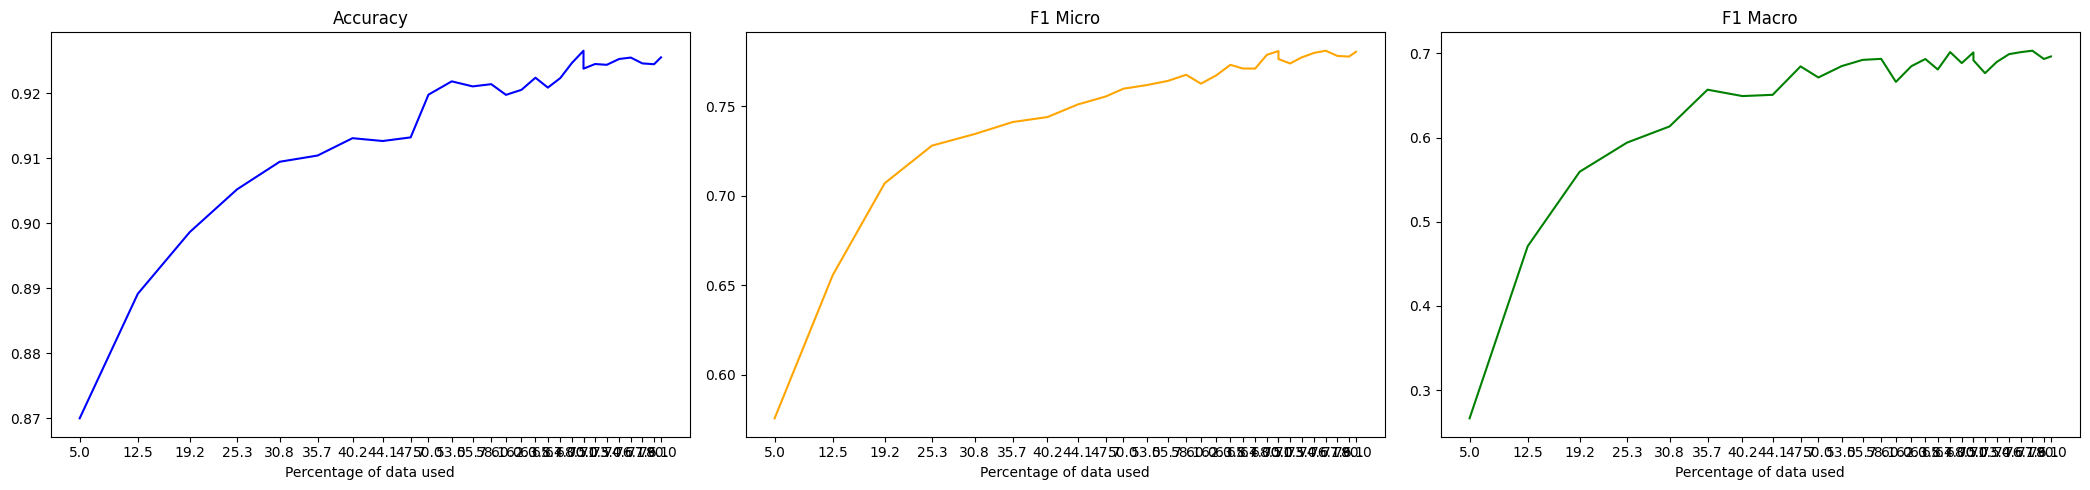

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6124, Accuracy: 0.8295, F1 Micro: 0.1273, F1 Macro: 0.0425
Epoch 2/10, Train Loss: 0.4669, Accuracy: 0.8283, F1 Micro: 0.0135, F1 Macro: 0.006
Epoch 3/10, Train Loss: 0.4072, Accuracy: 0.8326, F1 Micro: 0.0718, F1 Macro: 0.0278
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3847, Accuracy: 0.838, F1 Micro: 0.1376, F1 Macro: 0.0524
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3789, Accuracy: 0.8464, F1 Micro: 0.2428, F1 Macro: 0.0852
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3643, Accuracy: 0.8568, F1 Micro: 0.3734, F1 Macro: 0.1234
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3388, Accuracy: 0.8677, F1 Micro: 0.4735, F1 Macro: 0.2056
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3082, Accuracy: 0.8719, F1 Micro: 0.5043, F1 Macro: 0.2334
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2915, Accuracy: 0.8765, F1 Micro: 0.545, F1 Macro: 0.2588
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5666, Accuracy: 0.8156, F1 Micro: 0.2822, F1 Macro: 0.0565
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.463, Accuracy: 0.8337, F1 Micro: 0.3873, F1 Macro: 0.1394
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4113, Accuracy: 0.8662, F1 Micro: 0.5196, F1 Macro: 0.2574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3657, Accuracy: 0.8825, F1 Micro: 0.597, F1 Macro: 0.3513
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3357, Accuracy: 0.8895, F1 Micro: 0.6383, F1 Macro: 0.4492
Epoch 6/10, Train Loss: 0.2989, Accuracy: 0.8908, F1 Micro: 0.6096, F1 Macro: 0.4573
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2651, Accuracy: 0.8946, F1 Micro: 0.6839, F1 Macro: 0.547
Epoch 8/10, Train Loss: 0.237, Accuracy: 0.8967, F1 Micro: 0.6824, F1 Macro: 0.5473
Epoch 9/10, Train Loss: 0.2192, Accuracy: 0.8979, F1 Micro: 0.6574, F1 Macro: 0.529
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5245, Accuracy: 0.8248, F1 Micro: 0.4038, F1 Macro: 0.1241
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4158, Accuracy: 0.852, F1 Micro: 0.5586, F1 Macro: 0.2747
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3627, Accuracy: 0.8836, F1 Micro: 0.6151, F1 Macro: 0.3736
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3176, Accuracy: 0.8918, F1 Micro: 0.6158, F1 Macro: 0.3922
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2772, Accuracy: 0.8952, F1 Micro: 0.6318, F1 Macro: 0.4717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2443, Accuracy: 0.9007, F1 Micro: 0.6851, F1 Macro: 0.5267
Epoch 7/10, Train Loss: 0.2153, Accuracy: 0.903, F1 Micro: 0.6844, F1 Macro: 0.5392
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1883, Accuracy: 0.9012, F1 Micro: 0.6956, F1 Macro: 0.5498
Epoch 9/10, Train Loss: 0.1729, Accuracy: 0.9021, F1 Micro: 0.6892, F1 Macro: 0.5664
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.488, Accuracy: 0.8443, F1 Micro: 0.3908, F1 Macro: 0.1124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3586, Accuracy: 0.8817, F1 Micro: 0.5965, F1 Macro: 0.2994
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2916, Accuracy: 0.8918, F1 Micro: 0.647, F1 Macro: 0.4128
Epoch 4/10, Train Loss: 0.2551, Accuracy: 0.8953, F1 Micro: 0.6424, F1 Macro: 0.4756
Epoch 5/10, Train Loss: 0.2243, Accuracy: 0.8974, F1 Micro: 0.6409, F1 Macro: 0.4822
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1876, Accuracy: 0.9036, F1 Micro: 0.7001, F1 Macro: 0.5381
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1714, Accuracy: 0.9006, F1 Micro: 0.7154, F1 Macro: 0.5722
Epoch 8/10, Train Loss: 0.1458, Accuracy: 0.9015, F1 Micro: 0.7093, F1 Macro: 0.5794
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1318, Accuracy: 0.902, F1 Micro: 0.7201, F1 Macro: 0.5934
Epoch 10/10, Train Loss: 0.1119, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4687, Accuracy: 0.858, F1 Micro: 0.4782, F1 Macro: 0.196
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3447, Accuracy: 0.8778, F1 Micro: 0.638, F1 Macro: 0.3501
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2817, Accuracy: 0.8925, F1 Micro: 0.6681, F1 Macro: 0.4426
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.238, Accuracy: 0.8993, F1 Micro: 0.6857, F1 Macro: 0.5109
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.213, Accuracy: 0.9029, F1 Micro: 0.7097, F1 Macro: 0.542
Epoch 6/10, Train Loss: 0.1877, Accuracy: 0.9054, F1 Micro: 0.6946, F1 Macro: 0.5528
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1597, Accuracy: 0.9069, F1 Micro: 0.7101, F1 Macro: 0.5625
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1382, Accuracy: 0.9071, F1 Micro: 0.7128, F1 Macro: 0.5902
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1221, Accuracy: 0.9075, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4666, Accuracy: 0.8665, F1 Micro: 0.5138, F1 Macro: 0.2179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3379, Accuracy: 0.8903, F1 Micro: 0.6412, F1 Macro: 0.3895
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2786, Accuracy: 0.8994, F1 Micro: 0.6929, F1 Macro: 0.4986
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2379, Accuracy: 0.9045, F1 Micro: 0.7131, F1 Macro: 0.5617
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2037, Accuracy: 0.9075, F1 Micro: 0.726, F1 Macro: 0.5666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1768, Accuracy: 0.9107, F1 Micro: 0.7369, F1 Macro: 0.5966
Epoch 7/10, Train Loss: 0.1513, Accuracy: 0.9117, F1 Micro: 0.7318, F1 Macro: 0.6191
Epoch 8/10, Train Loss: 0.1297, Accuracy: 0.9104, F1 Micro: 0.7179, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.116, Accuracy: 0.9095, F1 Micro: 0.7393, F1 Macro: 0.6474
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4485, Accuracy: 0.8703, F1 Micro: 0.5829, F1 Macro: 0.266
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.315, Accuracy: 0.8927, F1 Micro: 0.6769, F1 Macro: 0.4485
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2557, Accuracy: 0.8994, F1 Micro: 0.7072, F1 Macro: 0.5222
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2206, Accuracy: 0.9078, F1 Micro: 0.7209, F1 Macro: 0.565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1787, Accuracy: 0.9107, F1 Micro: 0.7297, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1541, Accuracy: 0.9127, F1 Micro: 0.7309, F1 Macro: 0.5965
Epoch 7/10, Train Loss: 0.1351, Accuracy: 0.9121, F1 Micro: 0.7174, F1 Macro: 0.6183
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1138, Accuracy: 0.9116, F1 Micro: 0.7412, F1 Macro: 0.6464
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1026, Accuracy: 0.9109, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.438, Accuracy: 0.8757, F1 Micro: 0.5577, F1 Macro: 0.2546
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3051, Accuracy: 0.896, F1 Micro: 0.6622, F1 Macro: 0.3938
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2458, Accuracy: 0.904, F1 Micro: 0.7073, F1 Macro: 0.5314
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2091, Accuracy: 0.9103, F1 Micro: 0.7223, F1 Macro: 0.5592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1733, Accuracy: 0.9121, F1 Micro: 0.7432, F1 Macro: 0.6077
Epoch 6/10, Train Loss: 0.1483, Accuracy: 0.9137, F1 Micro: 0.7364, F1 Macro: 0.6123
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1206, Accuracy: 0.9071, F1 Micro: 0.7454, F1 Macro: 0.6525
Epoch 8/10, Train Loss: 0.1114, Accuracy: 0.9139, F1 Micro: 0.7394, F1 Macro: 0.6466
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0931, Accuracy: 0.9148, F1 Micro: 0.7491, F1 Macro: 0.6646
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4228, Accuracy: 0.8777, F1 Micro: 0.5644, F1 Macro: 0.2602
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2836, Accuracy: 0.8966, F1 Micro: 0.6787, F1 Macro: 0.4714
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2282, Accuracy: 0.9042, F1 Micro: 0.687, F1 Macro: 0.5138
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1975, Accuracy: 0.9108, F1 Micro: 0.7264, F1 Macro: 0.5683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.164, Accuracy: 0.9158, F1 Micro: 0.741, F1 Macro: 0.5948
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1345, Accuracy: 0.9127, F1 Micro: 0.7433, F1 Macro: 0.6146
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1142, Accuracy: 0.9142, F1 Micro: 0.7436, F1 Macro: 0.6443
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1025, Accuracy: 0.909, F1 Micro: 0.7461, F1 Macro: 0.6533
Epoch 9/10, Train Loss: 0.0877, Accuracy: 0.9146, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4223, Accuracy: 0.8792, F1 Micro: 0.5675, F1 Macro: 0.2586
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2845, Accuracy: 0.8964, F1 Micro: 0.6845, F1 Macro: 0.4141
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2282, Accuracy: 0.9052, F1 Micro: 0.7262, F1 Macro: 0.5561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.195, Accuracy: 0.9128, F1 Micro: 0.7414, F1 Macro: 0.5898
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1635, Accuracy: 0.9117, F1 Micro: 0.7454, F1 Macro: 0.6355
Epoch 6/10, Train Loss: 0.1381, Accuracy: 0.9164, F1 Micro: 0.7437, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1137, Accuracy: 0.9156, F1 Micro: 0.7489, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.102, Accuracy: 0.9181, F1 Micro: 0.7538, F1 Macro: 0.6703
Epoch 9/10, Train Loss: 0.0869, Accuracy: 0.9162, F1 Micro: 0.7504, F1 Macro: 0.686
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4233, Accuracy: 0.8795, F1 Micro: 0.5941, F1 Macro: 0.2771
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2939, Accuracy: 0.902, F1 Micro: 0.7062, F1 Macro: 0.4886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.232, Accuracy: 0.9103, F1 Micro: 0.728, F1 Macro: 0.5539
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1968, Accuracy: 0.912, F1 Micro: 0.7334, F1 Macro: 0.5398
Epoch 5/10, Train Loss: 0.1695, Accuracy: 0.916, F1 Micro: 0.7271, F1 Macro: 0.5896
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1414, Accuracy: 0.919, F1 Micro: 0.7466, F1 Macro: 0.6494
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1212, Accuracy: 0.9199, F1 Micro: 0.7562, F1 Macro: 0.6658
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0992, Accuracy: 0.9206, F1 Micro: 0.76, F1 Macro: 0.6776
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0901, Accuracy: 0.9196, F1 Micro: 0.76

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4151, Accuracy: 0.8792, F1 Micro: 0.5581, F1 Macro: 0.2641
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2849, Accuracy: 0.9015, F1 Micro: 0.679, F1 Macro: 0.4814
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2299, Accuracy: 0.9105, F1 Micro: 0.7209, F1 Macro: 0.5536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.9157, F1 Micro: 0.7444, F1 Macro: 0.5936
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1615, Accuracy: 0.919, F1 Micro: 0.7562, F1 Macro: 0.6165
Epoch 6/10, Train Loss: 0.1334, Accuracy: 0.9199, F1 Micro: 0.7534, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1192, Accuracy: 0.9204, F1 Micro: 0.7634, F1 Macro: 0.6684
Epoch 8/10, Train Loss: 0.0998, Accuracy: 0.9182, F1 Micro: 0.7612, F1 Macro: 0.6863
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0836, Accuracy: 0.9217, F1 Micro: 0.7646, F1 Macro: 0.688
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4113, Accuracy: 0.8828, F1 Micro: 0.5897, F1 Macro: 0.2739
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2803, Accuracy: 0.9027, F1 Micro: 0.7002, F1 Macro: 0.4896
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2292, Accuracy: 0.9103, F1 Micro: 0.7141, F1 Macro: 0.5476
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1929, Accuracy: 0.9169, F1 Micro: 0.7516, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1597, Accuracy: 0.9205, F1 Micro: 0.7606, F1 Macro: 0.63
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1346, Accuracy: 0.9229, F1 Micro: 0.7666, F1 Macro: 0.6648
Epoch 7/10, Train Loss: 0.1114, Accuracy: 0.9219, F1 Micro: 0.7641, F1 Macro: 0.6739
Epoch 8/10, Train Loss: 0.0992, Accuracy: 0.9195, F1 Micro: 0.7665, F1 Macro: 0.6821
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0809, Accuracy: 0.9195, F1 Micro: 0.7689, F1 Macro: 0.6977
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4061, Accuracy: 0.8821, F1 Micro: 0.5993, F1 Macro: 0.2808
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2765, Accuracy: 0.9013, F1 Micro: 0.6734, F1 Macro: 0.451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2239, Accuracy: 0.9103, F1 Micro: 0.705, F1 Macro: 0.5471
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1814, Accuracy: 0.9154, F1 Micro: 0.7559, F1 Macro: 0.607
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1587, Accuracy: 0.9189, F1 Micro: 0.7622, F1 Macro: 0.6377
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.9208, F1 Micro: 0.764, F1 Macro: 0.6801
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1093, Accuracy: 0.9221, F1 Micro: 0.7689, F1 Macro: 0.6766
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0946, Accuracy: 0.9227, F1 Micro: 0.7702, F1 Macro: 0.6888
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4063, Accuracy: 0.8829, F1 Micro: 0.5849, F1 Macro: 0.273
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2679, Accuracy: 0.9039, F1 Micro: 0.6986, F1 Macro: 0.4801
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2176, Accuracy: 0.9125, F1 Micro: 0.738, F1 Macro: 0.5621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1832, Accuracy: 0.9173, F1 Micro: 0.756, F1 Macro: 0.6033
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.9174, F1 Micro: 0.7587, F1 Macro: 0.6211
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1332, Accuracy: 0.9223, F1 Micro: 0.7705, F1 Macro: 0.6824
Epoch 7/10, Train Loss: 0.1127, Accuracy: 0.9246, F1 Micro: 0.769, F1 Macro: 0.6762
Epoch 8/10, Train Loss: 0.0941, Accuracy: 0.9182, F1 Micro: 0.7662, F1 Macro: 0.6772
Epoch 9/10, Train Loss: 0.0821, Accuracy: 0.919, F1 Micro: 0.7663, F1 Macro: 0.6889
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3981, Accuracy: 0.8836, F1 Micro: 0.5707, F1 Macro: 0.2729
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2648, Accuracy: 0.9046, F1 Micro: 0.6944, F1 Macro: 0.4704
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2138, Accuracy: 0.9136, F1 Micro: 0.7203, F1 Macro: 0.5469
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1803, Accuracy: 0.9156, F1 Micro: 0.7579, F1 Macro: 0.6094
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1495, Accuracy: 0.9191, F1 Micro: 0.7614, F1 Macro: 0.6226
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1303, Accuracy: 0.9231, F1 Micro: 0.7699, F1 Macro: 0.6784
Epoch 7/10, Train Loss: 0.1076, Accuracy: 0.9206, F1 Micro: 0.7689, F1 Macro: 0.693
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9223, F1 Micro: 0.7733, F1 Macro: 0.6987
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.9227, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3998, Accuracy: 0.8839, F1 Micro: 0.6083, F1 Macro: 0.2947
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2645, Accuracy: 0.9005, F1 Micro: 0.7048, F1 Macro: 0.5018
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2155, Accuracy: 0.9135, F1 Micro: 0.7384, F1 Macro: 0.5571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1783, Accuracy: 0.9139, F1 Micro: 0.7601, F1 Macro: 0.6138
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.9207, F1 Micro: 0.7691, F1 Macro: 0.6402
Epoch 6/10, Train Loss: 0.1282, Accuracy: 0.9195, F1 Micro: 0.7668, F1 Macro: 0.6721
Epoch 7/10, Train Loss: 0.1079, Accuracy: 0.9205, F1 Micro: 0.769, F1 Macro: 0.6905
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9222, F1 Micro: 0.7646, F1 Macro: 0.6951
Epoch 9/10, Train Loss: 0.0744, Accuracy: 0.9178, F1 Micro: 0.7672, F1 Macro: 0.6952
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.066, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3921, Accuracy: 0.8852, F1 Micro: 0.6314, F1 Macro: 0.307
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2623, Accuracy: 0.9044, F1 Micro: 0.6995, F1 Macro: 0.496
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.9138, F1 Micro: 0.744, F1 Macro: 0.5724
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.914, F1 Micro: 0.7469, F1 Macro: 0.5999
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1453, Accuracy: 0.9206, F1 Micro: 0.7669, F1 Macro: 0.6322
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.923, F1 Micro: 0.7721, F1 Macro: 0.6759
Epoch 7/10, Train Loss: 0.1049, Accuracy: 0.9229, F1 Micro: 0.7717, F1 Macro: 0.6676
Epoch 8/10, Train Loss: 0.0884, Accuracy: 0.9213, F1 Micro: 0.7702, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9248, F1 Micro: 0.7775, F1 Macro: 0.7107
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3898, Accuracy: 0.8847, F1 Micro: 0.6035, F1 Macro: 0.2982
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2611, Accuracy: 0.9074, F1 Micro: 0.7083, F1 Macro: 0.4838
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2042, Accuracy: 0.9132, F1 Micro: 0.7272, F1 Macro: 0.5533
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1748, Accuracy: 0.9219, F1 Micro: 0.7627, F1 Macro: 0.6129
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.9209, F1 Micro: 0.7663, F1 Macro: 0.6347
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1219, Accuracy: 0.9215, F1 Micro: 0.7663, F1 Macro: 0.6462
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.9236, F1 Micro: 0.7733, F1 Macro: 0.6922
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9215, F1 Micro: 0.7685, F1 Macro: 0.6918
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.923, F1 Micro: 0.7694, F1 Macro: 0.6961
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3846, Accuracy: 0.8872, F1 Micro: 0.634, F1 Macro: 0.3245
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2583, Accuracy: 0.9061, F1 Micro: 0.6936, F1 Macro: 0.4993
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2122, Accuracy: 0.9148, F1 Micro: 0.7475, F1 Macro: 0.5859
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.9114, F1 Micro: 0.7552, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1459, Accuracy: 0.9213, F1 Micro: 0.7707, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1225, Accuracy: 0.9242, F1 Micro: 0.7794, F1 Macro: 0.6914
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9225, F1 Micro: 0.7719, F1 Macro: 0.6922
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9242, F1 Micro: 0.7718, F1 Macro: 0.6914
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.9227, F1 Micro: 0.772, F1 Macro: 0.7003
Epoch 10/10, Train Loss: 0.0615, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3843, Accuracy: 0.8838, F1 Micro: 0.6411, F1 Macro: 0.314
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2544, Accuracy: 0.9015, F1 Micro: 0.7128, F1 Macro: 0.4996
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.208, Accuracy: 0.9144, F1 Micro: 0.7289, F1 Macro: 0.5401
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1729, Accuracy: 0.9199, F1 Micro: 0.7626, F1 Macro: 0.6172
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1465, Accuracy: 0.92, F1 Micro: 0.7701, F1 Macro: 0.6514
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.9216, F1 Micro: 0.7579, F1 Macro: 0.6634
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9236, F1 Micro: 0.772, F1 Macro: 0.6908
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9231, F1 Micro: 0.771, F1 Macro: 0.7029
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.9242, F1 Micro: 0.772, F1 Macro: 0.6918
Epoch 10/10, Train Loss: 0.0626, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3788, Accuracy: 0.8867, F1 Micro: 0.6181, F1 Macro: 0.3052
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2543, Accuracy: 0.9057, F1 Micro: 0.7049, F1 Macro: 0.5157
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2073, Accuracy: 0.9152, F1 Micro: 0.737, F1 Macro: 0.5626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.9203, F1 Micro: 0.7603, F1 Macro: 0.6154
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1432, Accuracy: 0.9217, F1 Micro: 0.7606, F1 Macro: 0.641
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1211, Accuracy: 0.9235, F1 Micro: 0.7655, F1 Macro: 0.6664
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1024, Accuracy: 0.9217, F1 Micro: 0.7712, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9233, F1 Micro: 0.7718, F1 Macro: 0.6877
Epoch 9/10, Train Loss: 0.0757, Accuracy: 0.9219, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3825, Accuracy: 0.8855, F1 Micro: 0.6287, F1 Macro: 0.3333
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.256, Accuracy: 0.9046, F1 Micro: 0.6816, F1 Macro: 0.4629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9114, F1 Micro: 0.7417, F1 Macro: 0.571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1682, Accuracy: 0.9199, F1 Micro: 0.7622, F1 Macro: 0.6142
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1445, Accuracy: 0.921, F1 Micro: 0.7647, F1 Macro: 0.6354
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1204, Accuracy: 0.9204, F1 Micro: 0.7728, F1 Macro: 0.6709
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9234, F1 Micro: 0.7657, F1 Macro: 0.6846
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9185, F1 Micro: 0.7739, F1 Macro: 0.6934
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0725, Accuracy: 0.9241, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3804, Accuracy: 0.8862, F1 Micro: 0.6437, F1 Macro: 0.3386
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2552, Accuracy: 0.9058, F1 Micro: 0.7127, F1 Macro: 0.4971
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2046, Accuracy: 0.9149, F1 Micro: 0.7224, F1 Macro: 0.5492
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9209, F1 Micro: 0.7612, F1 Macro: 0.6091
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1453, Accuracy: 0.9234, F1 Micro: 0.7717, F1 Macro: 0.6697
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1249, Accuracy: 0.9241, F1 Micro: 0.7736, F1 Macro: 0.6741
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.9234, F1 Micro: 0.7666, F1 Macro: 0.6854
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.9267, F1 Micro: 0.7826, F1 Macro: 0.7035
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.9219, F1 Micro: 0.7717, F1 Macro: 0.7011
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.379, Accuracy: 0.8879, F1 Micro: 0.6338, F1 Macro: 0.3319
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2545, Accuracy: 0.9072, F1 Micro: 0.7149, F1 Macro: 0.493
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2042, Accuracy: 0.9158, F1 Micro: 0.7443, F1 Macro: 0.5673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9204, F1 Micro: 0.7586, F1 Macro: 0.6065
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9245, F1 Micro: 0.7676, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1198, Accuracy: 0.9214, F1 Micro: 0.7765, F1 Macro: 0.681
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.922, F1 Micro: 0.7774, F1 Macro: 0.6983
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9262, F1 Micro: 0.7753, F1 Macro: 0.6975
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.9222, F1 Micro: 0.7714, F1 Macro: 0.6939
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3748, Accuracy: 0.8854, F1 Micro: 0.6094, F1 Macro: 0.3023
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2461, Accuracy: 0.9087, F1 Micro: 0.7168, F1 Macro: 0.5092
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2046, Accuracy: 0.9156, F1 Micro: 0.7312, F1 Macro: 0.5634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9185, F1 Micro: 0.7665, F1 Macro: 0.6187
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.9242, F1 Micro: 0.7723, F1 Macro: 0.6674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1194, Accuracy: 0.9249, F1 Micro: 0.7742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.099, Accuracy: 0.9216, F1 Micro: 0.7742, F1 Macro: 0.6978
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9236, F1 Micro: 0.7723, F1 Macro: 0.6974
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.9215, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.375, Accuracy: 0.8884, F1 Micro: 0.6187, F1 Macro: 0.3115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2481, Accuracy: 0.906, F1 Micro: 0.7194, F1 Macro: 0.5279
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2029, Accuracy: 0.9151, F1 Micro: 0.7483, F1 Macro: 0.5852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9178, F1 Micro: 0.7635, F1 Macro: 0.6172
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9211, F1 Micro: 0.7702, F1 Macro: 0.6361
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.923, F1 Micro: 0.7716, F1 Macro: 0.6792
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.9222, F1 Micro: 0.7782, F1 Macro: 0.6918
Epoch 8/10, Train Loss: 0.0812, Accuracy: 0.9229, F1 Micro: 0.7733, F1 Macro: 0.6904
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.9241, F1 Micro: 0.7722, F1 Macro: 0.7042
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3735, Accuracy: 0.8878, F1 Micro: 0.6287, F1 Macro: 0.316
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2479, Accuracy: 0.9063, F1 Micro: 0.72, F1 Macro: 0.5324
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.917, F1 Micro: 0.7352, F1 Macro: 0.557
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9191, F1 Micro: 0.7653, F1 Macro: 0.6194
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.9199, F1 Micro: 0.7728, F1 Macro: 0.6658
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.119, Accuracy: 0.9225, F1 Micro: 0.7736, F1 Macro: 0.6675
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0984, Accuracy: 0.9233, F1 Micro: 0.7743, F1 Macro: 0.6795
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.9255, F1 Micro: 0.7795, F1 Macro: 0.7008
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.070

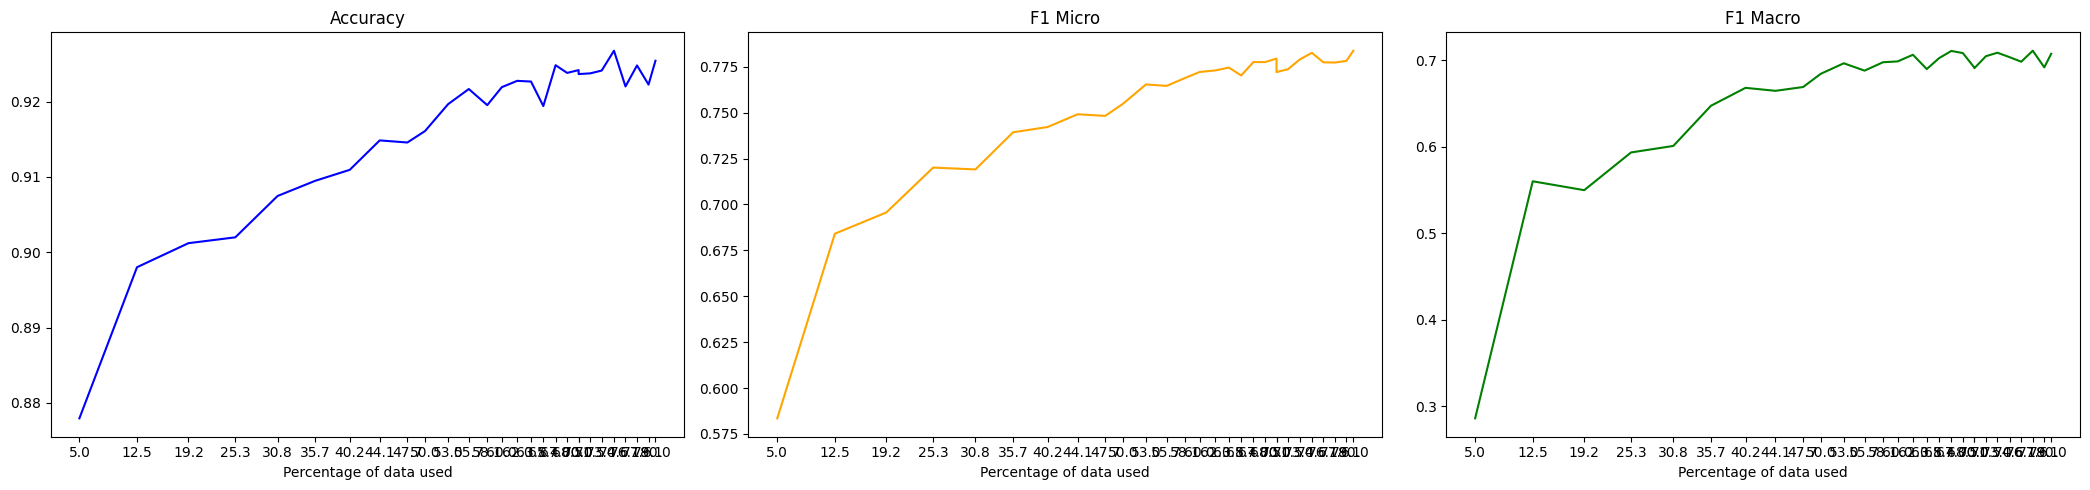

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6246, Accuracy: 0.8182, F1 Micro: 0.1799, F1 Macro: 0.0858
Epoch 2/10, Train Loss: 0.4638, Accuracy: 0.833, F1 Micro: 0.0996, F1 Macro: 0.0359
Epoch 3/10, Train Loss: 0.4095, Accuracy: 0.8315, F1 Micro: 0.0624, F1 Macro: 0.0249
Epoch 4/10, Train Loss: 0.4064, Accuracy: 0.8374, F1 Micro: 0.1245, F1 Macro: 0.0484
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3745, Accuracy: 0.8494, F1 Micro: 0.2754, F1 Macro: 0.0936
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3744, Accuracy: 0.8575, F1 Micro: 0.3823, F1 Macro: 0.1266
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.347, Accuracy: 0.8657, F1 Micro: 0.4875, F1 Macro: 0.2062
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.327, Accuracy: 0.8752, F1 Micro: 0.5421, F1 Macro: 0.2529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2895, Accuracy: 0.8767, F1 Micro: 0.5895, F1 Macro: 0.2828
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5243, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3607, Accuracy: 0.8279, F1 Micro: 0.0018, F1 Macro: 0.0007
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3194, Accuracy: 0.8538, F1 Micro: 0.3345, F1 Macro: 0.1179
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2879, Accuracy: 0.868, F1 Micro: 0.4738, F1 Macro: 0.2451
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2452, Accuracy: 0.878, F1 Micro: 0.5621, F1 Macro: 0.3541
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2187, Accuracy: 0.8834, F1 Micro: 0.5931, F1 Macro: 0.39
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1964, Accuracy: 0.8859, F1 Micro: 0.6539, F1 Macro: 0.4487
Epoch 8/10, Train Loss: 0.1753, Accuracy: 0.8881, F1 Micro: 0.6433, F1 Macro: 0.4439
Epoch 9/10, Train Loss: 0.1637, Accuracy: 0.8891, F1 Micro: 0.6281, F1 Macro: 0.4422
Higher F1 achi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4875, Accuracy: 0.845, F1 Micro: 0.3805, F1 Macro: 0.1318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3497, Accuracy: 0.8666, F1 Micro: 0.518, F1 Macro: 0.2356
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2965, Accuracy: 0.8814, F1 Micro: 0.6178, F1 Macro: 0.364
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2615, Accuracy: 0.8877, F1 Micro: 0.6353, F1 Macro: 0.4238
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2246, Accuracy: 0.8914, F1 Micro: 0.6571, F1 Macro: 0.4404
Epoch 6/10, Train Loss: 0.2186, Accuracy: 0.8913, F1 Micro: 0.6349, F1 Macro: 0.4563
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1842, Accuracy: 0.8934, F1 Micro: 0.6702, F1 Macro: 0.4795
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.168, Accuracy: 0.896, F1 Micro: 0.6815, F1 Macro: 0.5081
Epoch 9/10, Train Loss: 0.1493, Accuracy: 0.8972, F1 Micro: 0.6734, F1 Macro: 0.4981
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4636, Accuracy: 0.8495, F1 Micro: 0.357, F1 Macro: 0.1186
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3239, Accuracy: 0.8779, F1 Micro: 0.6009, F1 Macro: 0.3289
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2585, Accuracy: 0.8868, F1 Micro: 0.6026, F1 Macro: 0.3669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2164, Accuracy: 0.8943, F1 Micro: 0.6602, F1 Macro: 0.4514
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.195, Accuracy: 0.8937, F1 Micro: 0.6916, F1 Macro: 0.5157
Epoch 6/10, Train Loss: 0.1739, Accuracy: 0.8998, F1 Micro: 0.69, F1 Macro: 0.5183
Epoch 7/10, Train Loss: 0.1463, Accuracy: 0.8996, F1 Micro: 0.677, F1 Macro: 0.5209
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1315, Accuracy: 0.902, F1 Micro: 0.694, F1 Macro: 0.5561
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1102, Accuracy: 0.9025, F1 Micro: 0.7018, F1 Macro: 0.5691
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4532, Accuracy: 0.8548, F1 Micro: 0.4962, F1 Macro: 0.2174
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3136, Accuracy: 0.8857, F1 Micro: 0.607, F1 Macro: 0.3651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2573, Accuracy: 0.8939, F1 Micro: 0.6442, F1 Macro: 0.4002
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2185, Accuracy: 0.8974, F1 Micro: 0.6738, F1 Macro: 0.4841
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.19, Accuracy: 0.9014, F1 Micro: 0.6772, F1 Macro: 0.5161
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1601, Accuracy: 0.9017, F1 Micro: 0.6917, F1 Macro: 0.5315
Epoch 7/10, Train Loss: 0.1464, Accuracy: 0.8986, F1 Micro: 0.685, F1 Macro: 0.5602
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1301, Accuracy: 0.9054, F1 Micro: 0.7058, F1 Macro: 0.5753
Epoch 9/10, Train Loss: 0.1112, Accuracy: 0.9051, F1 Micro: 0.7057, F1 Macro: 0.5676
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4385, Accuracy: 0.8659, F1 Micro: 0.4739, F1 Macro: 0.1877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2918, Accuracy: 0.8882, F1 Micro: 0.6032, F1 Macro: 0.3882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2325, Accuracy: 0.8937, F1 Micro: 0.6912, F1 Macro: 0.508
Epoch 4/10, Train Loss: 0.2024, Accuracy: 0.9004, F1 Micro: 0.6765, F1 Macro: 0.4969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1763, Accuracy: 0.8974, F1 Micro: 0.7126, F1 Macro: 0.525
Epoch 6/10, Train Loss: 0.1495, Accuracy: 0.9064, F1 Micro: 0.7047, F1 Macro: 0.5535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1342, Accuracy: 0.909, F1 Micro: 0.7273, F1 Macro: 0.5836
Epoch 8/10, Train Loss: 0.1151, Accuracy: 0.9066, F1 Micro: 0.7224, F1 Macro: 0.5879
Epoch 9/10, Train Loss: 0.0984, Accuracy: 0.9033, F1 Micro: 0.7138, F1 Macro: 0.6168
Epoch 10/10, Train Loss: 0.0862, Accuracy: 0.9014, F1 Micro: 0.7212, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4176, Accuracy: 0.8655, F1 Micro: 0.4324, F1 Macro: 0.1729
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2775, Accuracy: 0.8904, F1 Micro: 0.6471, F1 Macro: 0.4381
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2169, Accuracy: 0.8987, F1 Micro: 0.6949, F1 Macro: 0.481
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1841, Accuracy: 0.9032, F1 Micro: 0.7116, F1 Macro: 0.4955
Epoch 5/10, Train Loss: 0.1607, Accuracy: 0.9067, F1 Micro: 0.7071, F1 Macro: 0.5415
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.137, Accuracy: 0.905, F1 Micro: 0.7235, F1 Macro: 0.5357
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1187, Accuracy: 0.9085, F1 Micro: 0.7321, F1 Macro: 0.5924
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1003, Accuracy: 0.9103, F1 Micro: 0.7347, F1 Macro: 0.6107
Epoch 9/10, Train Loss: 0.0892, Accuracy: 0.9092, F1 Micro: 0.7315, F1 Macro: 0.6092
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4057, Accuracy: 0.8723, F1 Micro: 0.4909, F1 Macro: 0.2201
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2697, Accuracy: 0.8942, F1 Micro: 0.6576, F1 Macro: 0.4195
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2125, Accuracy: 0.9017, F1 Micro: 0.6824, F1 Macro: 0.4626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1862, Accuracy: 0.9065, F1 Micro: 0.6896, F1 Macro: 0.5157
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1563, Accuracy: 0.9077, F1 Micro: 0.7254, F1 Macro: 0.5668
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.907, F1 Micro: 0.728, F1 Macro: 0.5643
Epoch 7/10, Train Loss: 0.1132, Accuracy: 0.9081, F1 Micro: 0.7251, F1 Macro: 0.6104
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0954, Accuracy: 0.9106, F1 Micro: 0.7357, F1 Macro: 0.6295
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0848, Accuracy: 0.9132, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3963, Accuracy: 0.8769, F1 Micro: 0.5665, F1 Macro: 0.2629
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.251, Accuracy: 0.8947, F1 Micro: 0.6605, F1 Macro: 0.4338
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.8978, F1 Micro: 0.696, F1 Macro: 0.5213
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.907, F1 Micro: 0.7156, F1 Macro: 0.5362
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1461, Accuracy: 0.9094, F1 Micro: 0.7283, F1 Macro: 0.5716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1258, Accuracy: 0.9102, F1 Micro: 0.7378, F1 Macro: 0.5986
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1082, Accuracy: 0.9112, F1 Micro: 0.7384, F1 Macro: 0.6017
Epoch 8/10, Train Loss: 0.0931, Accuracy: 0.9123, F1 Micro: 0.7379, F1 Macro: 0.6455
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.9101, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.399, Accuracy: 0.876, F1 Micro: 0.5814, F1 Macro: 0.2695
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2621, Accuracy: 0.8957, F1 Micro: 0.6785, F1 Macro: 0.484
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2126, Accuracy: 0.8991, F1 Micro: 0.7105, F1 Macro: 0.5352
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9087, F1 Micro: 0.7163, F1 Macro: 0.568
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.9118, F1 Micro: 0.7303, F1 Macro: 0.5841
Epoch 6/10, Train Loss: 0.1271, Accuracy: 0.9101, F1 Micro: 0.7275, F1 Macro: 0.5921
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.9134, F1 Micro: 0.7469, F1 Macro: 0.6508
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.9126, F1 Micro: 0.7483, F1 Macro: 0.6604
Epoch 9/10, Train Loss: 0.0824, Accuracy: 0.908, F1 Micro: 0.7371, F1 Macro: 0.6544
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3944, Accuracy: 0.877, F1 Micro: 0.5827, F1 Macro: 0.2751
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2516, Accuracy: 0.8962, F1 Micro: 0.653, F1 Macro: 0.4073
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2103, Accuracy: 0.9054, F1 Micro: 0.6968, F1 Macro: 0.5139
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.9085, F1 Micro: 0.7185, F1 Macro: 0.5629
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9138, F1 Micro: 0.7384, F1 Macro: 0.5839
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.121, Accuracy: 0.9083, F1 Micro: 0.7446, F1 Macro: 0.621
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.9153, F1 Micro: 0.7358, F1 Macro: 0.6358
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0894, Accuracy: 0.9082, F1 Micro: 0.7449, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0783, Accuracy: 0.9158, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3817, Accuracy: 0.8765, F1 Micro: 0.5983, F1 Macro: 0.2878
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2472, Accuracy: 0.8973, F1 Micro: 0.6952, F1 Macro: 0.494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2007, Accuracy: 0.9065, F1 Micro: 0.7075, F1 Macro: 0.5179
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.9092, F1 Micro: 0.7277, F1 Macro: 0.5653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9122, F1 Micro: 0.7364, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1267, Accuracy: 0.9121, F1 Micro: 0.7415, F1 Macro: 0.6068
Epoch 7/10, Train Loss: 0.0987, Accuracy: 0.9095, F1 Micro: 0.7344, F1 Macro: 0.6204
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9128, F1 Micro: 0.7542, F1 Macro: 0.6596
Epoch 9/10, Train Loss: 0.0753, Accuracy: 0.9119, F1 Micro: 0.7465, F1 Macro: 0.6733
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3847, Accuracy: 0.8786, F1 Micro: 0.5758, F1 Macro: 0.2706
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2523, Accuracy: 0.9, F1 Micro: 0.6814, F1 Macro: 0.4458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.9071, F1 Micro: 0.7046, F1 Macro: 0.5125
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9127, F1 Micro: 0.7248, F1 Macro: 0.5783
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9134, F1 Micro: 0.747, F1 Macro: 0.6043
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1246, Accuracy: 0.9131, F1 Micro: 0.7526, F1 Macro: 0.6268
Epoch 7/10, Train Loss: 0.1033, Accuracy: 0.9126, F1 Micro: 0.7454, F1 Macro: 0.6466
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.9172, F1 Micro: 0.7581, F1 Macro: 0.6672
Epoch 9/10, Train Loss: 0.076, Accuracy: 0.9122, F1 Micro: 0.7493, F1 Macro: 0.6645
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3843, Accuracy: 0.8795, F1 Micro: 0.5665, F1 Macro: 0.2634
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.248, Accuracy: 0.8986, F1 Micro: 0.6877, F1 Macro: 0.4578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2008, Accuracy: 0.9067, F1 Micro: 0.7269, F1 Macro: 0.5535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.9124, F1 Micro: 0.7401, F1 Macro: 0.5757
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.9168, F1 Micro: 0.7521, F1 Macro: 0.6063
Epoch 6/10, Train Loss: 0.1175, Accuracy: 0.9155, F1 Micro: 0.7515, F1 Macro: 0.6352
Epoch 7/10, Train Loss: 0.1009, Accuracy: 0.9132, F1 Micro: 0.744, F1 Macro: 0.6349
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.9122, F1 Micro: 0.7561, F1 Macro: 0.6641
Epoch 9/10, Train Loss: 0.075, Accuracy: 0.9134, F1 Micro: 0.7517, F1 Macro: 0.6712
Epoch 10/10, Train Loss: 0.0668, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3835, Accuracy: 0.8798, F1 Micro: 0.5658, F1 Macro: 0.277
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2461, Accuracy: 0.8998, F1 Micro: 0.6711, F1 Macro: 0.4378
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2011, Accuracy: 0.9072, F1 Micro: 0.7171, F1 Macro: 0.5239
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.914, F1 Micro: 0.7299, F1 Macro: 0.5826
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.9138, F1 Micro: 0.7486, F1 Macro: 0.5969
Epoch 6/10, Train Loss: 0.1189, Accuracy: 0.9091, F1 Micro: 0.7446, F1 Macro: 0.6216
Epoch 7/10, Train Loss: 0.1025, Accuracy: 0.9188, F1 Micro: 0.7478, F1 Macro: 0.6557
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.91, F1 Micro: 0.7475, F1 Macro: 0.6576
Epoch 9/10, Train Loss: 0.0747, Accuracy: 0.9093, F1 Micro: 0.7398, F1 Macro: 0.6724
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0644, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3732, Accuracy: 0.8827, F1 Micro: 0.6151, F1 Macro: 0.3073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2389, Accuracy: 0.8995, F1 Micro: 0.6966, F1 Macro: 0.517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.9035, F1 Micro: 0.733, F1 Macro: 0.5681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9101, F1 Micro: 0.7357, F1 Macro: 0.5691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1331, Accuracy: 0.9169, F1 Micro: 0.7431, F1 Macro: 0.6031
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1166, Accuracy: 0.9187, F1 Micro: 0.7577, F1 Macro: 0.6607
Epoch 7/10, Train Loss: 0.097, Accuracy: 0.915, F1 Micro: 0.7517, F1 Macro: 0.643
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.9148, F1 Micro: 0.7574, F1 Macro: 0.6768
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.9147, F1 Micro: 0.7527, F1 Macro: 0.668
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3775, Accuracy: 0.8807, F1 Micro: 0.6247, F1 Macro: 0.3092
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2428, Accuracy: 0.9015, F1 Micro: 0.6923, F1 Macro: 0.4367
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1973, Accuracy: 0.9058, F1 Micro: 0.7221, F1 Macro: 0.5725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9152, F1 Micro: 0.7449, F1 Macro: 0.5906
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9156, F1 Micro: 0.7521, F1 Macro: 0.6148
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9115, F1 Micro: 0.7517, F1 Macro: 0.6335
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.9134, F1 Micro: 0.7525, F1 Macro: 0.6623
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.919, F1 Micro: 0.7593, F1 Macro: 0.6543
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.916, F1 Micro: 0.7556, F1 Macro: 0.6669
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3752, Accuracy: 0.8831, F1 Micro: 0.597, F1 Macro: 0.2882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2426, Accuracy: 0.9033, F1 Micro: 0.6944, F1 Macro: 0.4962
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1953, Accuracy: 0.9089, F1 Micro: 0.6981, F1 Macro: 0.503
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.9116, F1 Micro: 0.7466, F1 Macro: 0.5883
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9167, F1 Micro: 0.7427, F1 Macro: 0.621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1205, Accuracy: 0.9178, F1 Micro: 0.7561, F1 Macro: 0.6485
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0952, Accuracy: 0.9188, F1 Micro: 0.7569, F1 Macro: 0.6702
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9171, F1 Micro: 0.7522, F1 Macro: 0.6603
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.917, F1 Micro: 0.7628, F1 Macro: 0.6782
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3685, Accuracy: 0.8836, F1 Micro: 0.6296, F1 Macro: 0.3172
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2471, Accuracy: 0.9041, F1 Micro: 0.6959, F1 Macro: 0.4712
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1927, Accuracy: 0.9131, F1 Micro: 0.7318, F1 Macro: 0.5703
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1622, Accuracy: 0.9168, F1 Micro: 0.7527, F1 Macro: 0.6001
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9142, F1 Micro: 0.7587, F1 Macro: 0.6329
Epoch 6/10, Train Loss: 0.1185, Accuracy: 0.9197, F1 Micro: 0.7562, F1 Macro: 0.6272
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.9166, F1 Micro: 0.7613, F1 Macro: 0.6746
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.9155, F1 Micro: 0.7567, F1 Macro: 0.6838
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9191, F1 Micro: 0.7678, F1 Macro: 0.6848
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.37, Accuracy: 0.885, F1 Micro: 0.607, F1 Macro: 0.3068
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2424, Accuracy: 0.9039, F1 Micro: 0.7101, F1 Macro: 0.5167
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1962, Accuracy: 0.911, F1 Micro: 0.7297, F1 Macro: 0.5794
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9172, F1 Micro: 0.7473, F1 Macro: 0.5964
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1396, Accuracy: 0.9184, F1 Micro: 0.7615, F1 Macro: 0.6333
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.9207, F1 Micro: 0.7626, F1 Macro: 0.6592
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9119, F1 Micro: 0.7455, F1 Macro: 0.6379
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9127, F1 Micro: 0.7561, F1 Macro: 0.6783
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.916, F1 Micro: 0.7553, F1 Macro: 0.6782
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3714, Accuracy: 0.8839, F1 Micro: 0.5854, F1 Macro: 0.2843
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2437, Accuracy: 0.9007, F1 Micro: 0.6536, F1 Macro: 0.4689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9116, F1 Micro: 0.7327, F1 Macro: 0.5677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9157, F1 Micro: 0.7545, F1 Macro: 0.6042
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.9199, F1 Micro: 0.765, F1 Macro: 0.6304
Epoch 6/10, Train Loss: 0.1149, Accuracy: 0.9149, F1 Micro: 0.7628, F1 Macro: 0.6465
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.9164, F1 Micro: 0.7655, F1 Macro: 0.6678
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9191, F1 Micro: 0.7665, F1 Macro: 0.6878
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.9185, F1 Micro: 0.7622, F1 Macro: 0.6868
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.8837, F1 Micro: 0.6257, F1 Macro: 0.3122
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2465, Accuracy: 0.8994, F1 Micro: 0.7143, F1 Macro: 0.5077
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1966, Accuracy: 0.9122, F1 Micro: 0.7321, F1 Macro: 0.5708
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.9141, F1 Micro: 0.7492, F1 Macro: 0.6024
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1386, Accuracy: 0.9161, F1 Micro: 0.7609, F1 Macro: 0.6342
Epoch 6/10, Train Loss: 0.1201, Accuracy: 0.9172, F1 Micro: 0.7609, F1 Macro: 0.6575
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.9191, F1 Micro: 0.7626, F1 Macro: 0.6602
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9148, F1 Micro: 0.7614, F1 Macro: 0.6709
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0726, Accuracy: 0.9196, F1 Micro: 0.7698, F1 Macro: 0.7012
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3745, Accuracy: 0.8868, F1 Micro: 0.6318, F1 Macro: 0.3237
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2432, Accuracy: 0.8988, F1 Micro: 0.7094, F1 Macro: 0.4797
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2027, Accuracy: 0.9108, F1 Micro: 0.7353, F1 Macro: 0.584
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.9186, F1 Micro: 0.7616, F1 Macro: 0.6083
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9176, F1 Micro: 0.7607, F1 Macro: 0.6354
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1136, Accuracy: 0.9214, F1 Micro: 0.7618, F1 Macro: 0.6375
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.9153, F1 Micro: 0.763, F1 Macro: 0.675
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9192, F1 Micro: 0.7668, F1 Macro: 0.682
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.9178, F1 Micro: 0.7633, F1 Macro: 0.6815
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3718, Accuracy: 0.8869, F1 Micro: 0.6375, F1 Macro: 0.3487
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2435, Accuracy: 0.9055, F1 Micro: 0.7068, F1 Macro: 0.5017
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1985, Accuracy: 0.9143, F1 Micro: 0.7462, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1632, Accuracy: 0.9185, F1 Micro: 0.7488, F1 Macro: 0.5948
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1383, Accuracy: 0.9205, F1 Micro: 0.7667, F1 Macro: 0.6274
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9205, F1 Micro: 0.7646, F1 Macro: 0.6603
Epoch 7/10, Train Loss: 0.0968, Accuracy: 0.9157, F1 Micro: 0.7535, F1 Macro: 0.6708
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0801, Accuracy: 0.92, F1 Micro: 0.7679, F1 Macro: 0.6785
Epoch 9/10, Train Loss: 0.0692, Accuracy: 0.9207, F1 Micro: 0.7669, F1 Macro: 0.6864
Epoch 10/10, Train Loss: 0.0618, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3718, Accuracy: 0.8833, F1 Micro: 0.6393, F1 Macro: 0.3956
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2429, Accuracy: 0.9076, F1 Micro: 0.7217, F1 Macro: 0.5312
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1985, Accuracy: 0.9145, F1 Micro: 0.732, F1 Macro: 0.5813
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9204, F1 Micro: 0.7536, F1 Macro: 0.5991
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.9156, F1 Micro: 0.7567, F1 Macro: 0.6363
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.118, Accuracy: 0.9187, F1 Micro: 0.7656, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.0961, Accuracy: 0.9153, F1 Micro: 0.7645, F1 Macro: 0.6565
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0817, Accuracy: 0.9177, F1 Micro: 0.7667, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07, Accuracy: 0.9231, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3684, Accuracy: 0.8867, F1 Micro: 0.6154, F1 Macro: 0.3479
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2468, Accuracy: 0.9062, F1 Micro: 0.715, F1 Macro: 0.5275
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9155, F1 Micro: 0.7495, F1 Macro: 0.5799
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9165, F1 Micro: 0.7619, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.9209, F1 Micro: 0.764, F1 Macro: 0.6152
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.918, F1 Micro: 0.765, F1 Macro: 0.66
Epoch 7/10, Train Loss: 0.0988, Accuracy: 0.9179, F1 Micro: 0.7621, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.9222, F1 Micro: 0.7702, F1 Macro: 0.6716
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.9235, F1 Micro: 0.7762,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3689, Accuracy: 0.889, F1 Micro: 0.6393, F1 Macro: 0.352
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2429, Accuracy: 0.9067, F1 Micro: 0.6984, F1 Macro: 0.5095
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1971, Accuracy: 0.9147, F1 Micro: 0.7458, F1 Macro: 0.5818
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9196, F1 Micro: 0.741, F1 Macro: 0.594
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.141, Accuracy: 0.9204, F1 Micro: 0.7616, F1 Macro: 0.6352
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1146, Accuracy: 0.9236, F1 Micro: 0.7745, F1 Macro: 0.6604
Epoch 7/10, Train Loss: 0.0988, Accuracy: 0.918, F1 Micro: 0.7717, F1 Macro: 0.6919
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9209, F1 Micro: 0.769, F1 Macro: 0.6722
Epoch 9/10, Train Loss: 0.0716, Accuracy: 0.9197, F1 Micro: 0.7693, F1 Macro: 0.6856
Epoch 10/10, Train Loss: 0.0605, Accuracy: 0.9188, F1 Micro: 0.7688, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3718, Accuracy: 0.8853, F1 Micro: 0.5835, F1 Macro: 0.3183
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2471, Accuracy: 0.9083, F1 Micro: 0.7155, F1 Macro: 0.5191
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.9178, F1 Micro: 0.7464, F1 Macro: 0.5761
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9202, F1 Micro: 0.7671, F1 Macro: 0.6205
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9196, F1 Micro: 0.7721, F1 Macro: 0.6527
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.9258, F1 Micro: 0.7708, F1 Macro: 0.6575
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0987, Accuracy: 0.9234, F1 Micro: 0.778, F1 Macro: 0.6836
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9279, F1 Micro: 0.7829, F1 Macro: 0.6986
Epoch 9/10, Train Loss: 0.0692, Accuracy: 0.9235, F1 Micro: 0.7785, F1 Macro: 0.7026
Epoch 1

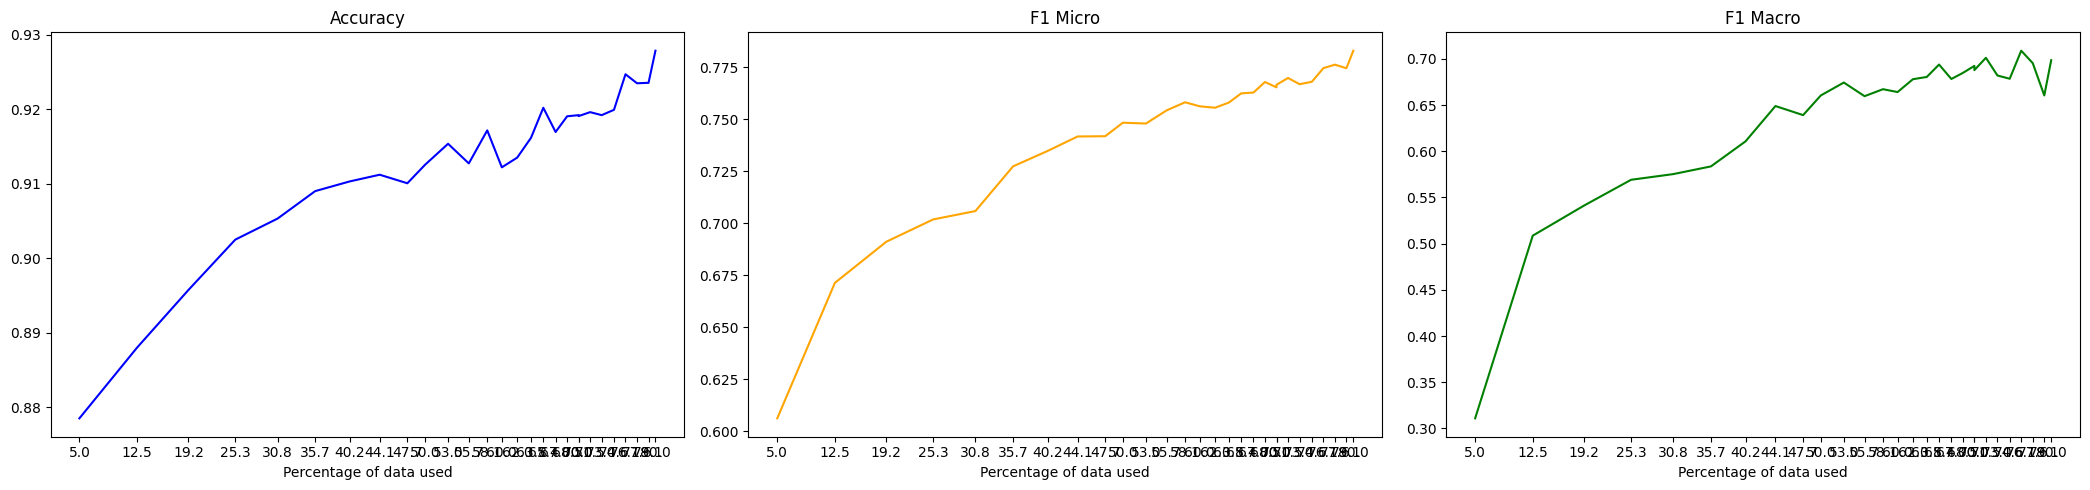

In [ ]:
active_learning(seeds[4], 4)